### ============================================
# Parkinson's Disease vs Control EEG Classifier
# Full Pipeline: BIDS loading, Preprocessing, ICA, Feature Extraction, ML
# Dataset: ds002778 (BIDS format)
# ============================================

import os
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, get_entity_vals
from mne.preprocessing import ICA, create_eog_epochs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [1]:
import os
import openneuro

# Define BIDS root folder
bids_root = "PD1"
os.makedirs(bids_root, exist_ok=True)

# Download dataset (all subjects, all sessions)
openneuro.download(dataset="ds002778", target_dir=bids_root)

print("✅ Download complete.")



👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds002778 …


📁 Traversing directories for ds002778 : 0 entities [00:00, ? entities/s]

KeyboardInterrupt: 

In [2]:
import os

subjects = [d for d in os.listdir(bids_root) if d.startswith("sub-")]
print(f"👥 Subjects found ({len(subjects)} total):")
for subject in subjects:
    print(f" - {subject}")


👥 Subjects found (31 total):
 - sub-hc4
 - sub-hc2
 - sub-hc25
 - sub-hc24
 - sub-hc30
 - sub-pd3
 - sub-hc31
 - sub-pd5
 - sub-pd23
 - sub-pd12
 - sub-pd13
 - sub-pd14
 - sub-pd22
 - sub-hc7
 - sub-hc1
 - sub-hc8
 - sub-hc10
 - sub-hc21
 - sub-hc20
 - sub-hc18
 - sub-hc29
 - sub-pd9
 - sub-hc33
 - sub-pd6
 - sub-hc32
 - sub-pd11
 - sub-pd16
 - sub-pd28
 - sub-pd17
 - sub-pd19
 - sub-pd26


In [3]:
import os
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load participant-level data
df = pd.read_csv('PD1/participants.tsv', sep='\t')

# Encode categorical variables
le_gender = LabelEncoder()
df['gender'] = le_gender.fit_transform(df['gender'])

le_hand = LabelEncoder()
df['hand'] = le_hand.fit_transform(df['hand'])

# Initialize
features = []
labels = []
subject_ids = []

bids_root = "PD1"  # top-level BIDS directory

# Walk through all subject/session folders
for subject in os.listdir(bids_root):
    subj_path = os.path.join(bids_root, subject)
    if not os.path.isdir(subj_path) or not subject.startswith("sub-"):
        continue

    subj_row = df[df["participant_id"] == subject]
    if subj_row.empty:
        print(f"Skipping {subject}: not in participants.tsv")
        continue
    subj_row = subj_row.iloc[0]

    # Extract demographic/clinical data
    age = subj_row["age"]
    gender = subj_row["gender"]
    hand = subj_row["hand"]
    mmse = subj_row["MMSE"]
    naart = subj_row["NAART"]
    disease_duration = subj_row["disease_duration"] if not pd.isna(subj_row["disease_duration"]) else 0

    # Loop through sessions (ses-on, ses-off, ses-hc)
    for session in os.listdir(subj_path):
        if not session.startswith("ses-"):
            continue

        session_path = os.path.join(subj_path, session)
        if not os.path.isdir(session_path):
            continue

        # Determine label from session type
        if session == "ses-hc":
            label = 0  # Control
        elif session == "ses-on":
            label = 1  # PD-On
        elif session == "ses-off":
            label = 2  # PD-Off
        else:
            print(f"Unknown session {session} for {subject}, skipping.")
            continue

        # Append feature vector and label
        features.append(np.array([age, gender, hand, mmse, naart, disease_duration]))
        labels.append(label)
        subject_ids.append(f"{subject}_{session}")

# Convert to tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Print basic info
print(f"Features tensor shape: {features_tensor.shape}")
print(f"Labels tensor shape: {labels_tensor.shape}")
print(f"Label counts: {np.bincount(labels_tensor.numpy())}")


Features tensor shape: torch.Size([46, 6])
Labels tensor shape: torch.Size([46])
Label counts: [16 15 15]


/var/folders/xf/s2p9hhss1mn1j7qc3djhm7hw0000gn/T/ipykernel_52290/3203488211.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  features_tensor = torch.tensor(features, dtype=torch.float32)


## Step 1: Define Feature Extraction Function

## Step 2: Preprocess and Extract for Subject

In [4]:
import time
import psutil
import numpy as np
import mne
import os
from mne.preprocessing import ICA, create_eog_epochs
from mne_bids import BIDSPath, read_raw_bids

# --- Feature extraction function (assumed to exist) ---
# from your_module import extract_band_power_epochs

# Categorize session types
def categorize_session(session_name):
    if 'ses-on' in session_name:
        return 'pd-on'
    elif 'ses-off' in session_name:
        return 'pd-off'
    elif 'ses-hc' in session_name:
        return 'ctl'
    else:
        return 'unknown'

# Preprocess and extract features
def preprocess_and_extract_features(raw_data):
    print("Starting preprocessing and feature extraction...")

    # 1. Create synthetic events (if no annotations)
    print("Creating synthetic events...")
    if len(raw_data.annotations) == 0:
        events = np.array([
            [i * int(raw_data.info['sfreq'] * 2), 0, 1]
            for i in range(int(raw_data.n_times / (raw_data.info['sfreq'] * 2)))
        ])
    else:
        events, _ = mne.events_from_annotations(raw_data)

    # 2. Filtering
    print("Filtering data (1-50 Hz)...")
    raw_data.filter(l_freq=1, h_freq=50)

    # 3. Detect bad channels
    raw_data.info['bads'] = []  # Customize this logic as needed
    if raw_data.info['bads']:
        print("Interpolating bad channels...")
        raw_data.interpolate_bads()
    else:
        print("No bad channels detected.")

    # 4. ICA for artifact removal
    print("Running ICA...")
    ica = ICA(n_components=20, random_state=97, max_iter=800)
    ica.fit(raw_data)

    eog_channel_name = 'EXG1'
    if eog_channel_name in raw_data.info['ch_names']:
        eog_indices, _ = ica.find_bads_eog(raw_data, ch_name=eog_channel_name)
        ica.exclude = eog_indices
    raw_data_cleaned = ica.apply(raw_data)

    # 5. Epoching (2s fixed-length)
    print("Epoching data...")
    try:
        epochs = mne.Epochs(raw_data_cleaned, events, event_id=None, tmin=0, tmax=2, baseline=(0, 0), detrend=1, preload=True)
        print(f"Epoching completed. {len(epochs)} epochs created.")
    except Exception as e:
        print(f"Error during epoching: {e}")
        return None

    return epochs

# Full subject/session processing pipeline
def process_subject(subject, session, label, bids_root, duration=2.0, overlap=1.0):
    try:
        print(f"🚀 Processing {subject}, {session}")

        bids_path = BIDSPath(
            root=bids_root,
            subject=subject,
            session=session,
            task='rest',
            datatype='eeg',
            suffix='eeg'
        )
        print(f"📂 BIDS path: {bids_path}")

        raw = read_raw_bids(bids_path=bids_path, verbose=True)
        raw.set_channel_types({
            "EXG1": "eog", "EXG2": "eog", "EXG3": "eog", "EXG4": "eog",
            "EXG5": "eog", "EXG6": "eog", "EXG7": "eog", "EXG8": "eog"
        })
        raw.set_montage("standard_1020", on_missing="ignore")
        raw.load_data()

        # Filter and ICA steps
        raw.filter(1., 40.)
        raw.notch_filter(60.)
        raw.set_eeg_reference('average')

        ica = ICA(n_components=20, random_state=97)
        ica.fit(raw)

        eog_epochs = create_eog_epochs(raw)
        eog_inds, _ = ica.find_bads_eog(eog_epochs)
        ica.exclude = eog_inds
        raw = ica.apply(raw)

        # Epoching
        epochs = mne.make_fixed_length_epochs(raw, duration=duration, overlap=overlap, preload=True)
        if len(epochs) == 0:
            print(f"⚠️ No epochs for {subject}, session {session}")
            return [], [], []

        # Feature extraction (replace with your actual method)
        print(f"🧠 Extracting features...")
        X_subject, feature_names = extract_band_power_epochs(epochs, compress=False, apply_pca=False)  # No PCA and no compression
        y_subject = [label] * len(X_subject)

        print(f"✅ Features extracted: {len(X_subject)} samples")
        return X_subject, y_subject, feature_names

    except Exception as e:
        print(f"❌ Error processing {subject}, session {session}: {e}")
        return [], [], []

# Dummy entity getter (customize if needed)
def get_entity_vals(bids_root, entity_key='subject'):
    return ['sub-pd1', 'sub-pd2', 'sub-hc1', 'sub-hc2']



## Step 3: Loop Over All Subjects

In [5]:
import time
import psutil
import numpy as np
import mne
import os
from mne.preprocessing import ICA, create_eog_epochs
from mne_bids import BIDSPath, read_raw_bids
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.decomposition import PCA

def extract_band_power_epochs(
    epochs,
    bands=[(1, 4), (4, 8), (8, 13), (13, 30)],
    compress=False,
    apply_pca=False,
    pca_components=50
):
    psd = epochs.compute_psd()
    psd_data, freqs = psd.get_data(return_freqs=True)
    ch_names = epochs.info['ch_names']
    X = []

    feature_names = []
    for fmin, fmax in bands:
        for ch in ch_names:
            feature_names.append(f"{int(fmin)}-{int(fmax)}Hz_{ch}")

    for trial in psd_data:
        features = []
        for fmin, fmax in bands:
            idx = np.logical_and(freqs >= fmin, freqs <= fmax)
            band_power = trial[:, idx].mean(axis=1)
            features.extend(band_power)
        X.append(features)

    X = np.array(X)
    pca_model = None

    if apply_pca:
        n_samples, n_features = X.shape
        if pca_components is None or pca_components > min(n_samples, n_features):
            pca_components = min(n_samples, n_features)
            print(f"Auto-adjusting PCA to {pca_components} components")

        print(f"Applying PCA: reducing from {X.shape[1]} → {pca_components} dimensions")
        pca_model = PCA(n_components=pca_components, random_state=42)
        X = pca_model.fit_transform(X)
        feature_names = [f"PCA_{i+1}" for i in range(X.shape[1])]

    return X, feature_names, pca_model

def categorize_session(session_name):
    if 'ses-on' in session_name:
        return 'pd-on'
    elif 'ses-off' in session_name:
        return 'pd-off'
    elif 'ses-hc' in session_name:
        return 'ctl'
    else:
        return 'unknown'

def preprocess_and_extract_features(raw_data):
    print("Starting preprocessing and feature extraction...")

    if len(raw_data.annotations) == 0:
        events = np.array([
            [i * int(raw_data.info['sfreq'] * 2), 0, 1]
            for i in range(int(raw_data.n_times / (raw_data.info['sfreq'] * 2)))
        ])
    else:
        events, _ = mne.events_from_annotations(raw_data)

    print("Filtering data (1-50 Hz)...")
    raw_data.filter(l_freq=1, h_freq=50)

    raw_data.info['bads'] = []
    if raw_data.info['bads']:
        print("Interpolating bad channels...")
        raw_data.interpolate_bads()
    else:
        print("No bad channels detected.")

    print("Running ICA...")
    ica = ICA(n_components=20, random_state=97, max_iter=800)
    ica.fit(raw_data)

    eog_channel_name = 'EXG1'
    if eog_channel_name in raw_data.info['ch_names']:
        eog_indices, _ = ica.find_bads_eog(raw_data, ch_name=eog_channel_name)
        ica.exclude = eog_indices
    raw_data_cleaned = ica.apply(raw_data)

    print("Epoching data...")
    try:
        epochs = mne.Epochs(raw_data_cleaned, events, event_id=None, tmin=0, tmax=2, baseline=(0, 0), detrend=1, preload=True)
        print(f"Epoching completed. {len(epochs)} epochs created.")
    except Exception as e:
        print(f"Error during epoching: {e}")
        return None

    return epochs

def process_bids_dataset(dataset_dir):
    valid_subjects = {'pd-on': [], 'pd-off': [], 'ctl': []}
    sample_counts = {'pd-on': 0, 'pd-off': 0, 'ctl': 0}
    feature_counts = {'pd-on': 0, 'pd-off': 0, 'ctl': 0}
    errors = []
    total_samples = 0
    total_features = 0

    X = []
    y = []

    for index, subject_id in enumerate(os.listdir(dataset_dir)):
        subject_path = os.path.join(dataset_dir, subject_id)
        if os.path.isdir(subject_path):
            session_processed = set()
            session_dirs = ['ses-hc', 'ses-on', 'ses-off']
            for session_dir in session_dirs:
                if session_dir in session_processed:
                    continue

                session_path = os.path.join(subject_path, session_dir, 'eeg')
                if os.path.isdir(session_path):
                    bdf_files = [f for f in os.listdir(session_path) if f.endswith('.bdf')]
                    if len(bdf_files) == 0:
                        print(f"No BDF files found for subject {subject_id} in session {session_dir}. Skipping...")
                        continue

                    print(f"Processing subject {subject_id} in session {session_dir} with {len(bdf_files)} BDF files...")

                    try:
                        start_time = time.time()

                        raw_data = mne.io.read_raw_bdf(os.path.join(session_path, bdf_files[0]), preload=True)
                        print(f"Loaded raw data for subject {subject_id}, session {session_dir}.")

                        epochs = preprocess_and_extract_features(raw_data)

                        if epochs is None:
                            raise ValueError(f"Error processing data for subject {subject_id}, session {session_dir}. Skipping.")

                        X_subject, feature_names, _ = extract_band_power_epochs(epochs, compress=False, apply_pca=False)

                        n_samples = len(X_subject)
                        n_features = X_subject.shape[1]
                        total_samples += n_samples
                        total_features = n_features

                        X.extend(X_subject)
                        y.extend([categorize_session(session_dir)] * n_samples)

                        category = categorize_session(session_dir)
                        valid_subjects[category].append(f"{subject_id} ({session_dir})")
                        sample_counts[category] += n_samples
                        feature_counts[category] = n_features

                        session_processed.add(session_dir)
                        print(f"Time taken for subject {subject_id}, session {session_dir}: {time.time() - start_time} seconds")

                    except Exception as e:
                        print(f"Error processing subject {subject_id}, session {session_dir}: {e}")
                        errors.append((subject_id, session_dir, str(e)))

    X = np.array(X)
    y = np.array([0 if label == 'ctl' else 1 if label == 'pd-on' else 2 for label in y])

    print("\nSummary of valid subjects and errors:\n")
    for category in ['pd-on', 'pd-off', 'ctl']:
        print(f"Total number of subjects in {category.upper()}: {len(valid_subjects[category])}")
        print(f"Total samples in {category.upper()}: {sample_counts[category]}")
        print(f"Total features in {category.upper()}: {feature_counts[category]}")
        for subject in valid_subjects[category]:
            print(f"- {subject}")

    print("\nErrors encountered:")
    for subject, session, error in errors:
        print(f"- {subject} ({session}): {error}")

    print(f"\nTotal samples across all categories: {total_samples}")
    print(f"Total features (channels): {total_features}")
    print(f"✅ Feature matrix shape: {X.shape}")
    print(f"✅ Label vector shape: {y.shape}")

    unique_labels, label_counts = np.unique(y, return_counts=True)
    print(f"Label distribution: {dict(zip(unique_labels, label_counts))}")

    return X, y, valid_subjects, errors, total_samples, total_features, sample_counts, feature_counts

# Example usage
dataset_dir = 'PD1'
X, y, valid_subjects, errors, total_samples, total_features, sample_counts, feature_counts = process_bids_dataset(dataset_dir)


Processing subject sub-hc4 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc4/ses-hc/eeg/sub-hc4_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 92671  =      0.000 ...   180.998 secs...
Loaded raw data for subject sub-hc4, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1691 samples (3.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.6s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
Epoching completed. 90 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc4, session ses-hc: 2.655565023422241 seconds
Processing subject sub-hc2 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc2/ses-hc/eeg/sub-hc2_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 99327  =      0.000 ...   193.998 secs...
Loaded raw data for subject sub-hc2, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.2s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 96 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc2, session ses-hc: 2.169779062271118 seconds
Processing subject sub-hc25 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc25/ses-hc/eeg/sub-hc25_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 103423  =      0.000 ...   201.998 secs...
Loaded raw data for subject sub-hc25, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower tra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 100 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc25, session ses-hc: 2.0094809532165527 seconds
Processing subject sub-hc24 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc24/ses-hc/eeg/sub-hc24_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
Loaded raw data for subject sub-hc24, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower t

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.4s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 95 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc24, session ses-hc: 2.378838062286377 seconds
Processing subject sub-hc30 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc30/ses-hc/eeg/sub-hc30_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96767  =      0.000 ...   188.998 secs...
Loaded raw data for subject sub-hc30, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower tra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.1s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. 94 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc30, session ses-hc: 1.9886012077331543 seconds
Processing subject sub-pd3 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd3/ses-on/eeg/sub-pd3_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 109055  =      0.000 ...   212.998 secs...
Loaded raw data for subject sub-pd3, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower trans

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Using data from preloaded Raw for 106 events and 1025 original time points ...
0 bad epochs dropped
Epoching completed. 106 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd3, session ses-on: 2.050365924835205 seconds
Processing subject sub-pd3 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd3/ses-off/eeg/sub-pd3_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 102399  =      0.000 ...   199.998 secs...
Loaded raw data for subject sub-pd3, session ses-off.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 99 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd3, session ses-off: 1.8880198001861572 seconds
Processing subject sub-hc31 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc31/ses-hc/eeg/sub-hc31_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 95743  =      0.000 ...   186.998 secs...
Loaded raw data for subject sub-hc31, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower tr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Epoching data...
Not setting metadata
93 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 93 events and 1025 original time points ...
0 bad epochs dropped
Epoching completed. 93 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc31, session ses-hc: 1.7669358253479004 seconds
Processing subject sub-pd5 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd5/ses-on/eeg/sub-pd5_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 105471  =      0.000 ...   205.998 secs...
Loaded raw data for subject sub-pd5, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a o

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 102 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd5, session ses-on: 2.0229501724243164 seconds
Processing subject sub-pd5 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd5/ses-off/eeg/sub-pd5_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 100863  =      0.000 ...   196.998 secs...
Loaded raw data for subject sub-pd5, session ses-off.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower t

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.6s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


98 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 98 events and 1025 original time points ...
0 bad epochs dropped
Epoching completed. 98 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd5, session ses-off: 2.6879329681396484 seconds
Processing subject sub-pd23 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd23/ses-on/eeg/sub-pd23_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 95231  =      0.000 ...   185.998 secs...
Loaded raw data for subject sub-pd23, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal ban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.5s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 92 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd23, session ses-on: 3.4059860706329346 seconds
Processing subject sub-pd23 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd23/ses-off/eeg/sub-pd23_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 104447  =      0.000 ...   203.998 secs...
Loaded raw data for subject sub-pd23, session ses-off.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Low

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.7s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 102 events and 1025 original time points ...
1 bad epochs dropped
Epoching completed. 101 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd23, session ses-off: 2.6370699405670166 seconds
Processing subject sub-pd12 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd12/ses-on/eeg/sub-pd12_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
Loaded raw data for subject sub-pd12, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Window

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.4s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 95 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd12, session ses-on: 2.4228317737579346 seconds
Processing subject sub-pd12 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd12/ses-off/eeg/sub-pd12_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 105983  =      0.000 ...   206.998 secs...
Loaded raw data for subject sub-pd12, session ses-off.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Low

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.1s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. 103 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd12, session ses-off: 3.0738282203674316 seconds
Processing subject sub-pd13 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd13/ses-on/eeg/sub-pd13_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 95743  =      0.000 ...   186.998 secs...
Loaded raw data for subject sub-pd13, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.4s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. 93 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd13, session ses-on: 3.3860042095184326 seconds
Processing subject sub-pd13 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd13/ses-off/eeg/sub-pd13_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 95231  =      0.000 ...   185.998 secs...
Loaded raw data for subject sub-pd13, session ses-off.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lowe

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 92 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd13, session ses-off: 1.671724796295166 seconds
Processing subject sub-pd14 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd14/ses-on/eeg/sub-pd14_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96767  =      0.000 ...   188.998 secs...
Loaded raw data for subject sub-pd14, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower tr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.2s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. 94 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd14, session ses-on: 2.1972270011901855 seconds
Processing subject sub-pd14 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd14/ses-off/eeg/sub-pd14_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149503  =      0.000 ...   291.998 secs...
Loaded raw data for subject sub-pd14, session ses-off.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Low

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.4s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 146 events and 1025 original time points ...
1 bad epochs dropped
Epoching completed. 145 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd14, session ses-off: 2.6863090991973877 seconds
Processing subject sub-pd22 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd22/ses-on/eeg/sub-pd22_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 94207  =      0.000 ...   183.998 secs...
Loaded raw data for subject sub-pd22, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Window

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.1s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 91 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd22, session ses-on: 2.016724109649658 seconds
Processing subject sub-pd22 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd22/ses-off/eeg/sub-pd22_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96255  =      0.000 ...   187.998 secs...
Loaded raw data for subject sub-pd22, session ses-off.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


1 bad epochs dropped
Epoching completed. 93 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd22, session ses-off: 1.8616158962249756 seconds
Processing subject sub-hc7 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
Loaded raw data for subject sub-hc7, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower trans

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.7s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 95 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc7, session ses-hc: 3.751275062561035 seconds
Processing subject sub-hc1 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
Loaded raw data for subject sub-hc1, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.0s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 projection items activated
Using data from preloaded Raw for 96 events and 1025 original time points ...
1 bad epochs dropped
Epoching completed. 95 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc1, session ses-hc: 3.0376529693603516 seconds
Processing subject sub-hc8 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc8/ses-hc/eeg/sub-hc8_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97791  =      0.000 ...   190.998 secs...
Loaded raw data for subject sub-hc8, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming wi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.2s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. 95 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc8, session ses-hc: 3.0702199935913086 seconds
Processing subject sub-hc10 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc10/ses-hc/eeg/sub-hc10_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 102911  =      0.000 ...   200.998 secs...
Loaded raw data for subject sub-hc10, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower tr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.5s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. 100 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc10, session ses-hc: 2.5526208877563477 seconds
Processing subject sub-hc21 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc21/ses-hc/eeg/sub-hc21_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96767  =      0.000 ...   188.998 secs...
Loaded raw data for subject sub-hc21, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower t

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. 94 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc21, session ses-hc: 1.8763151168823242 seconds
Processing subject sub-hc20 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc20/ses-hc/eeg/sub-hc20_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 94207  =      0.000 ...   183.998 secs...
Loaded raw data for subject sub-hc20, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower tr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.7s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 91 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc20, session ses-hc: 2.5904061794281006 seconds
Processing subject sub-hc18 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc18/ses-hc/eeg/sub-hc18_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 95231  =      0.000 ...   185.998 secs...
Loaded raw data for subject sub-hc18, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower tr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.5s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


1 bad epochs dropped
Epoching completed. 92 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc18, session ses-hc: 2.393662929534912 seconds
Processing subject sub-hc29 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc29/ses-hc/eeg/sub-hc29_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 101887  =      0.000 ...   198.998 secs...
Loaded raw data for subject sub-hc29, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower tr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. 99 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc29, session ses-hc: 1.9436750411987305 seconds
Processing subject sub-pd9 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd9/ses-on/eeg/sub-pd9_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 95743  =      0.000 ...   186.998 secs...
Loaded raw data for subject sub-pd9, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.0s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
Epoching completed. 93 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd9, session ses-on: 2.913700819015503 seconds
Processing subject sub-pd9 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd9/ses-off/eeg/sub-pd9_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97791  =      0.000 ...   190.998 secs...
Loaded raw data for subject sub-pd9, session ses-off.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower tran

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.3s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
Epoching completed. 95 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd9, session ses-off: 2.2818028926849365 seconds
Processing subject sub-hc33 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc33/ses-hc/eeg/sub-hc33_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97279  =      0.000 ...   189.998 secs...
Loaded raw data for subject sub-hc33, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower tr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.2s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 94 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc33, session ses-hc: 2.153881788253784 seconds
Processing subject sub-pd6 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd6/ses-on/eeg/sub-pd6_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 147967  =      0.000 ...   288.998 secs...
Loaded raw data for subject sub-pd6, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 2.0s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. 144 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd6, session ses-on: 3.3252689838409424 seconds
Processing subject sub-pd6 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97791  =      0.000 ...   190.998 secs...
Loaded raw data for subject sub-pd6, session ses-off.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower tr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. 95 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd6, session ses-off: 1.955286979675293 seconds
Processing subject sub-hc32 in session ses-hc with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-hc32/ses-hc/eeg/sub-hc32_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 100351  =      0.000 ...   195.998 secs...
Loaded raw data for subject sub-hc32, session ses-hc.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower tr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 1.2s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


98 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 98 events and 1025 original time points ...
1 bad epochs dropped
Epoching completed. 97 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-hc32, session ses-hc: 2.2465507984161377 seconds
Processing subject sub-pd11 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd11/ses-on/eeg/sub-pd11_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 95743  =      0.000 ...   186.998 secs...
Loaded raw data for subject sub-pd11, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal ban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. 93 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd11, session ses-on: 1.9441258907318115 seconds
Processing subject sub-pd11 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd11/ses-off/eeg/sub-pd11_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 95231  =      0.000 ...   185.998 secs...
Loaded raw data for subject sub-pd11, session ses-off.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lowe

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


1 bad epochs dropped
Epoching completed. 92 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd11, session ses-off: 1.9003589153289795 seconds
Processing subject sub-pd16 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd16/ses-on/eeg/sub-pd16_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 95743  =      0.000 ...   186.998 secs...
Loaded raw data for subject sub-pd16, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower t

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.8s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

/var/folders/xf/s2p9hhss1mn1j7qc3djhm7hw0000gn/T/ipykernel_52290/1233013522.py:86: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (40) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw_data)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 40 PCA components
Epoching data...
Not setting metadata
93 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 93 events and 1025 original time points ...
0 bad epochs dropped
Epoching completed. 93 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd16, session ses-on: 2.7467219829559326 seconds
Processing subject sub-pd16 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd16/ses-off/eeg/sub-pd16_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96255  =      0.000 ...   187.998 secs...
Loaded raw data for subject sub-pd16, session ses-off.
Starting preprocessing and feature extraction...
Filtering data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.3s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 93 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd16, session ses-off: 3.2898309230804443 seconds
Processing subject sub-pd28 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd28/ses-on/eeg/sub-pd28_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 102911  =      0.000 ...   200.998 secs...
Loaded raw data for subject sub-pd28, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 2.2s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. 100 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd28, session ses-on: 3.2201521396636963 seconds
Processing subject sub-pd28 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd28/ses-off/eeg/sub-pd28_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 105471  =      0.000 ...   205.998 secs...
Loaded raw data for subject sub-pd28, session ses-off.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 1.2s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 102 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd28, session ses-off: 2.2041337490081787 seconds
Processing subject sub-pd17 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd17/ses-on/eeg/sub-pd17_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 95231  =      0.000 ...   185.998 secs...
Loaded raw data for subject sub-pd17, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 92 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd17, session ses-on: 1.490797758102417 seconds
Processing subject sub-pd17 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd17/ses-off/eeg/sub-pd17_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96767  =      0.000 ...   188.998 secs...
Loaded raw data for subject sub-pd17, session ses-off.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Using data from preloaded Raw for 94 events and 1025 original time points ...
0 bad epochs dropped
Epoching completed. 94 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd17, session ses-off: 1.7850701808929443 seconds
Processing subject sub-pd19 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd19/ses-on/eeg/sub-pd19_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96255  =      0.000 ...   187.998 secs...
Loaded raw data for subject sub-pd19, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.5s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


1 bad epochs dropped
Epoching completed. 93 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd19, session ses-on: 2.488266944885254 seconds
Processing subject sub-pd19 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd19/ses-off/eeg/sub-pd19_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 94719  =      0.000 ...   184.998 secs...
Loaded raw data for subject sub-pd19, session ses-off.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 40 PCA components
Epoching data...
Not setting metadata
92 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 92 events and 1025 original time points ...
0 bad epochs dropped
Epoching completed. 92 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd19, session ses-off: 1.762727975845337 seconds
Processing subject sub-pd26 in session ses-on with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd26/ses-on/eeg/sub-pd26_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 110591  =      0.000 ...   215.998 secs...
Loaded raw data for subject sub-pd26, session ses-on.
Starting preprocessing and feature extraction...
Filtering data (1

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.6s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
Epoching completed. 107 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd26, session ses-on: 2.793226957321167 seconds
Processing subject sub-pd26 in session ses-off with 1 BDF files...
Extracting EDF parameters from /Users/uarc/Downloads/PD1/sub-pd26/ses-off/eeg/sub-pd26_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97791  =      0.000 ...   190.998 secs...
Loaded raw data for subject sub-pd26, session ses-off.
Starting preprocessing and feature extraction...
Filtering data (1-50 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lowe

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.8s.
Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
Epoching completed. 95 epochs created.
    Using multitaper spectrum estimation with 7 DPSS windows
Time taken for subject sub-pd26, session ses-off: 2.7358789443969727 seconds

Summary of valid subjects and errors:

Total number of subjects in PD-ON: 15
Total samples in PD-ON: 1488
Total features in PD-ON: 160
- sub-pd3 (ses-on)
- sub-pd5 (ses-on)
- sub-pd23 (ses-on)
- sub-pd12 (ses-on)
- sub-pd13 (ses-on)
- sub-pd14 (ses-on)
- sub-pd22 (ses-on)
- sub-pd9 (ses-on)
- sub-pd6 (ses-on)
- sub-pd11 (ses-on)
- sub-pd16 (ses-on)
- sub-pd28 (ses-on)
- sub-pd17 (ses-on)
- sub-pd19 (ses-on)
- sub-pd26 (ses-on)
Total number of subjects in PD-OFF: 15
Total samples in PD-OFF: 1489
Total features in PD-OFF: 160
- sub-pd3 (ses-off)
- sub-pd5 (ses-off)
- sub-pd23 (ses-off)
- sub-pd12 (ses-off)
- sub-pd13 (ses-off)
- sub-pd14 (ses-off)
- sub-pd22 (ses-off)
- sub-pd9 (ses-off)
- sub-pd6 (ses-off)
- sub-pd11 (ses-off)
- sub-pd16 (ses-off)
- sub-pd28 (ses-off)
- sub-pd17 (ses-off)
- 

### Debug

## Step 4: Train ML Classifier

### Train Random Forest Classifier

In [6]:
from sklearn.model_selection import train_test_split

# Assuming X and y have been processed and are available

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print the shapes of the resulting datasets
print(f"✅ Shape of X_train: {X_train.shape}")
print(f"✅ Shape of X_test: {X_test.shape}")
print(f"✅ Shape of y_train: {y_train.shape}")
print(f"✅ Shape of y_test: {y_test.shape}")

# Check the first epoch in the dataset
print(f"First sample (epoch) shape: {X[0].shape}")
print(f"First sample (epoch) data: {X[0]}")



✅ Shape of X_train: (3597, 160)
✅ Shape of X_test: (900, 160)
✅ Shape of y_train: (3597,)
✅ Shape of y_test: (900,)
First sample (epoch) shape: (160,)
First sample (epoch) data: [1.24609666e-09 6.92827308e-10 1.63676004e-09 1.67530169e-09
 5.24635248e-10 1.95857244e-09 1.55398154e-09 2.73604785e-10
 3.83798953e-10 7.34349060e-10 7.77521426e-10 1.31118466e-09
 6.00786112e-10 6.20474497e-10 1.76139677e-09 1.25330601e-09
 1.84334554e-09 1.67700096e-09 1.29811697e-09 1.94551762e-09
 1.90998116e-09 4.40095527e-10 1.35361077e-09 3.23746542e-09
 1.47716659e-09 4.03442698e-10 1.45425527e-09 2.95789324e-09
 1.81754628e-09 1.48184812e-09 7.27512177e-10 1.37421672e-10
 2.40438990e-09 3.11286872e-09 1.34464860e-09 2.40434751e-09
 1.44775931e-07 1.59805264e-07 1.00474399e-08 8.24811126e-09
 9.94401767e-10 6.34338703e-10 1.20406943e-09 5.09621985e-10
 1.56197768e-10 5.55747022e-10 1.44277903e-09 1.47821604e-10
 1.76989612e-10 7.64354168e-10 1.22912998e-09 5.52472701e-10
 4.65489143e-10 8.82874034e-1

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

# Assuming X and y have been processed and are available
# Ensure y is a 1D NumPy array if it’s a pandas series or dataframe
if isinstance(y, pd.Series):
    y = y.values
elif isinstance(y, pd.DataFrame):
    y = y.squeeze().values

# 🎯 Class names
class_names = ['Control', 'PD-On', 'PD-Off']
n_classes = len(class_names)

# ⚙️ Cross-Validation Setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 🧪 Metrics tracking
all_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "auc": []
}

# 🔄 Fold Loop
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n📁 Fold {fold}")
    
    # Splitting data into training and test sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # ⚖️ Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 🌳 Random Forest Model
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_scaled, y_train)
    
    # Make predictions and probabilities
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)
    
    # 📈 Metrics
    acc = np.mean(y_pred == y_test)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))  # Binarize for multi-class ROC
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

    # 📊 Append
    all_metrics["accuracy"].append(acc)
    all_metrics["precision"].append(prec)
    all_metrics["recall"].append(rec)
    all_metrics["f1"].append(f1)
    all_metrics["auc"].append(auc_score)

    # 🧾 Classification Report
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    
    # Display the classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # 🔵 Confusion Matrix (blue)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # 📉 ROC Curve (macro-averaged)
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    
    # Compute macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    plt.figure(figsize=(6, 5))
    plt.plot(all_fpr, mean_tpr, color='blue', label=f'Macro-Averaged ROC (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Macro ROC Curve - Fold {fold}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# 📊 Overall Summary
print("\n📊 Overall Cross-Validation Summary:")
for key in all_metrics:
    mean_val = np.mean(all_metrics[key])
    print(f"Mean {key.capitalize():<9}: {mean_val:.4f}")


NameError: name 'y' is not defined

# ***Decision Tree***

In [42]:
!pip install plotly



📁 Fold 1
Accuracy:  0.8011
Precision: 0.8010
Recall:    0.8008
F1-Score:  0.8006
AUC Score: 0.8406

Classification Report:
              precision    recall  f1-score   support

     Control       0.84      0.85      0.84       304
       PD-On       0.77      0.81      0.79       298
      PD-Off       0.79      0.74      0.77       298

    accuracy                           0.80       900
   macro avg       0.80      0.80      0.80       900
weighted avg       0.80      0.80      0.80       900



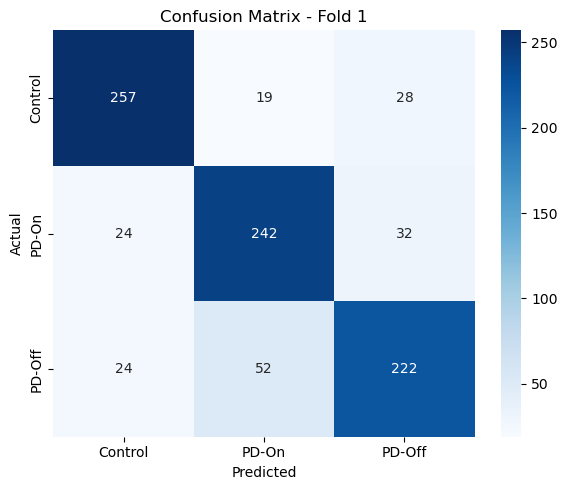

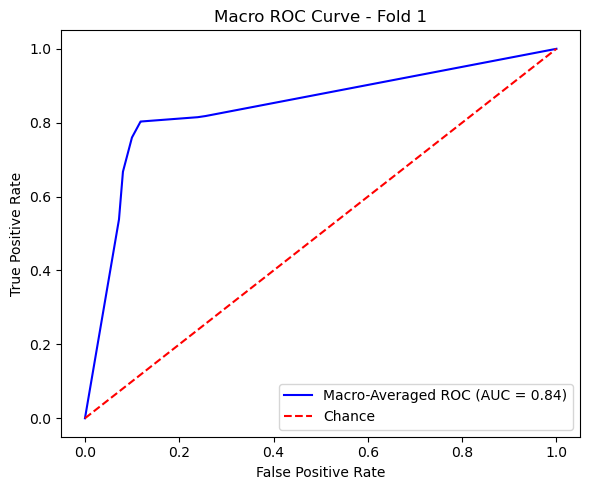


📁 Fold 2
Accuracy:  0.8167
Precision: 0.8169
Recall:    0.8163
F1-Score:  0.8164
AUC Score: 0.8624

Classification Report:
              precision    recall  f1-score   support

     Control       0.87      0.87      0.87       304
       PD-On       0.80      0.78      0.79       298
      PD-Off       0.77      0.81      0.79       298

    accuracy                           0.82       900
   macro avg       0.82      0.82      0.82       900
weighted avg       0.82      0.82      0.82       900



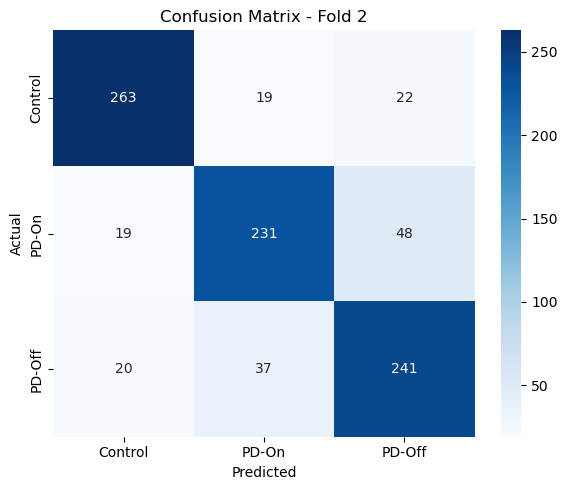

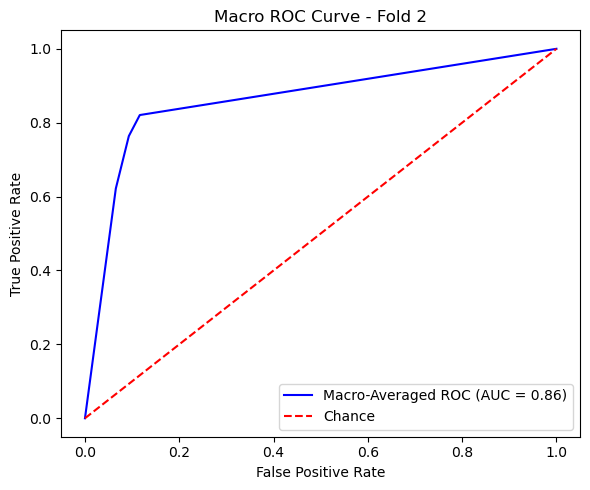


📁 Fold 3
Accuracy:  0.8354
Precision: 0.8351
Recall:    0.8349
F1-Score:  0.8345
AUC Score: 0.8756

Classification Report:
              precision    recall  f1-score   support

     Control       0.88      0.89      0.88       304
       PD-On       0.81      0.85      0.83       298
      PD-Off       0.82      0.76      0.79       297

    accuracy                           0.84       899
   macro avg       0.84      0.83      0.83       899
weighted avg       0.84      0.84      0.83       899



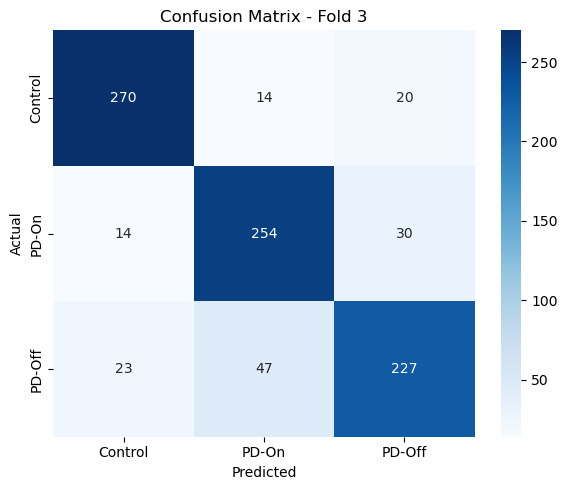

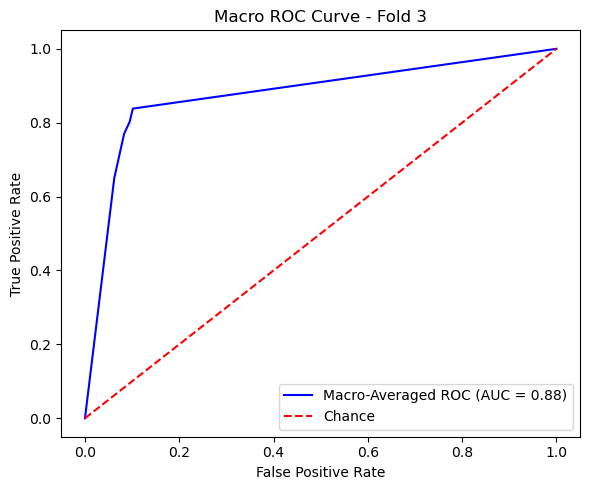


📁 Fold 4
Accuracy:  0.8020
Precision: 0.8020
Recall:    0.8016
F1-Score:  0.8017
AUC Score: 0.8515

Classification Report:
              precision    recall  f1-score   support

     Control       0.87      0.86      0.86       304
       PD-On       0.76      0.78      0.77       297
      PD-Off       0.78      0.76      0.77       298

    accuracy                           0.80       899
   macro avg       0.80      0.80      0.80       899
weighted avg       0.80      0.80      0.80       899



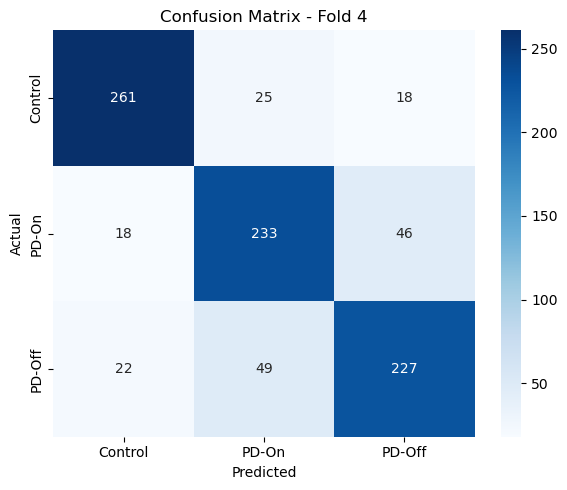

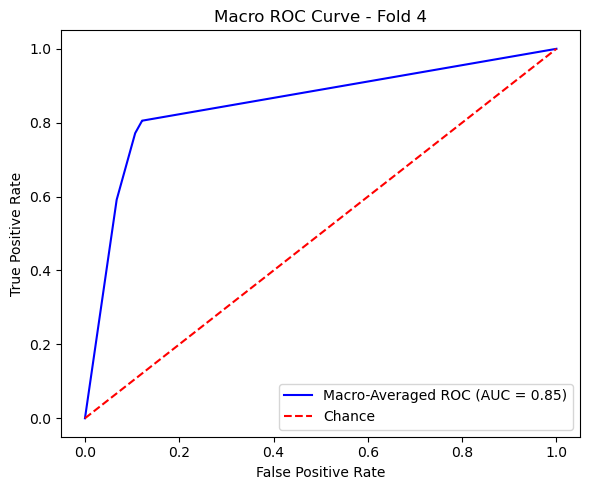


📁 Fold 5
Accuracy:  0.8176
Precision: 0.8162
Recall:    0.8169
F1-Score:  0.8163
AUC Score: 0.8638

Classification Report:
              precision    recall  f1-score   support

     Control       0.87      0.90      0.88       304
       PD-On       0.79      0.76      0.77       297
      PD-Off       0.79      0.79      0.79       298

    accuracy                           0.82       899
   macro avg       0.82      0.82      0.82       899
weighted avg       0.82      0.82      0.82       899



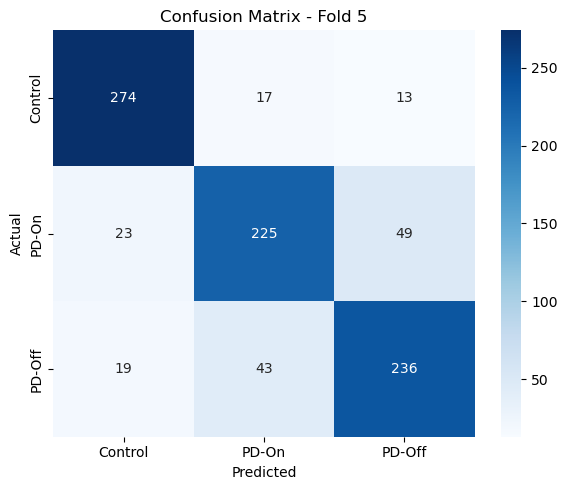

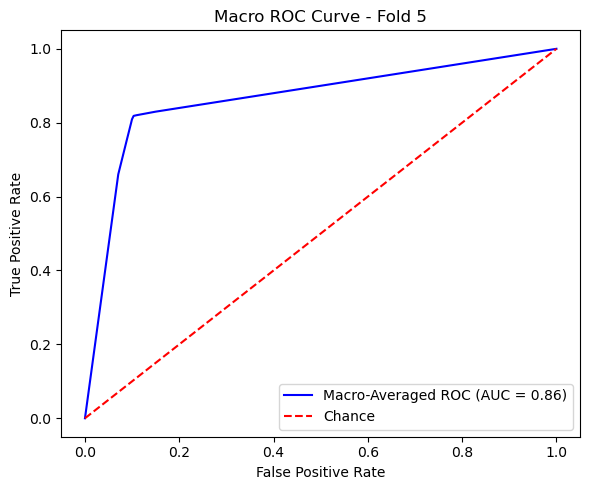


📊 Overall Cross-Validation Summary:
Mean Accuracy : 0.8145
Mean Precision: 0.8142
Mean Recall   : 0.8141
Mean F1       : 0.8139
Mean Auc      : 0.8588


In [55]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

# Assuming X and y have been processed and are available
# Ensure y is a 1D NumPy array if it’s a pandas series or dataframe
if isinstance(y, pd.Series):
    y = y.values
elif isinstance(y, pd.DataFrame):
    y = y.squeeze().values

# 🎯 Class names
class_names = ['Control', 'PD-On', 'PD-Off']
n_classes = len(class_names)

# ⚙️ Cross-Validation Setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 🧪 Metrics tracking
all_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "auc": []
}

# 🔄 Fold Loop
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n📁 Fold {fold}")
    
    # Splitting data into training and test sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # ⚖️ Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 🌳 Decision Tree Model
    model = DecisionTreeClassifier(
        max_depth=20,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    
    # Make predictions and probabilities
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)
    
    # 📈 Metrics
    acc = np.mean(y_pred == y_test)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))  # Binarize for multi-class ROC
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

    # 📊 Append
    all_metrics["accuracy"].append(acc)
    all_metrics["precision"].append(prec)
    all_metrics["recall"].append(rec)
    all_metrics["f1"].append(f1)
    all_metrics["auc"].append(auc_score)

    # 🧾 Classification Report
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    
    # Display the classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # 🔵 Confusion Matrix (blue)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # 📉 ROC Curve (macro-averaged)
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    
    # Compute macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    plt.figure(figsize=(6, 5))
    plt.plot(all_fpr, mean_tpr, color='blue', label=f'Macro-Averaged ROC (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Macro ROC Curve - Fold {fold}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# 📊 Overall Summary
print("\n📊 Overall Cross-Validation Summary:")
for key in all_metrics:
    mean_val = np.mean(all_metrics[key])
    print(f"Mean {key.capitalize():<9}: {mean_val:.4f}")



In [65]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# === Plot the Final Decision Tree Model with Adjustments ===
plt.figure(figsize=(150, 75))  # Decrease the size of the figure to avoid overcrowding

# Visualizing the decision tree using plot_tree function
plot_tree(
    model,  # The trained decision tree model
    filled=True,  # Color the nodes to make them more readable
    feature_names=['Feature' + str(i) for i in range(X_train_scaled.shape[1])],  # Feature names (e.g., Feature0, Feature1, ...)
    class_names=class_names,  # Class names for each target class (Control, PD-On, PD-Off)
    rounded=True,  # Round the corners of the nodes for better aesthetics
    fontsize=10,  # Reduce font size to avoid overcrowding
    proportion=True,  # Show proportion of samples in each node
    precision=2  # Precision of float values displayed on the tree
)

# Add a title to the plot
plt.title("Final Decision Tree Visualization", fontsize=8)

# Adjust layout to avoid clipping of labels and titles
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05)

# Display the plot
plt.show()



### Step 4.2 : Train Support Vector Machine Classifier


📁 Fold 1
Accuracy:  0.8811
Precision: 0.8809
Recall:    0.8808
F1-Score:  0.8807
AUC Score: 0.9540

Classification Report:
              precision    recall  f1-score   support

     Control       0.92      0.92      0.92       304
       PD-On       0.85      0.88      0.87       298
      PD-Off       0.86      0.84      0.85       298

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



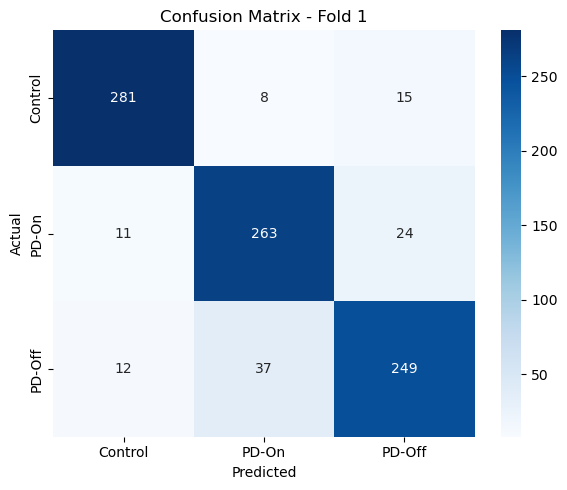

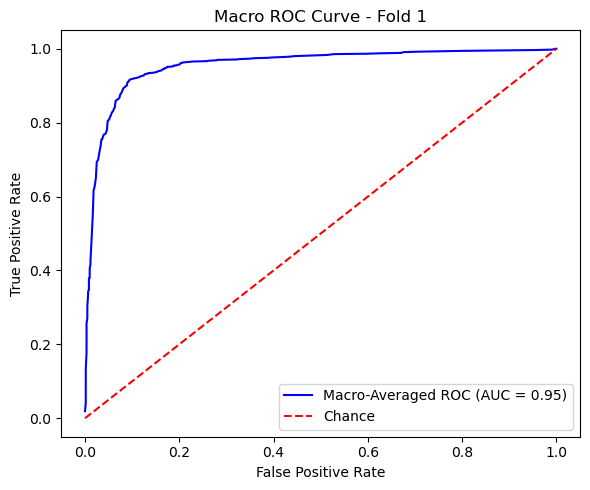


📁 Fold 2
Accuracy:  0.9033
Precision: 0.9030
Recall:    0.9029
F1-Score:  0.9024
AUC Score: 0.9663

Classification Report:
              precision    recall  f1-score   support

     Control       0.92      0.97      0.95       304
       PD-On       0.88      0.88      0.88       298
      PD-Off       0.91      0.86      0.88       298

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



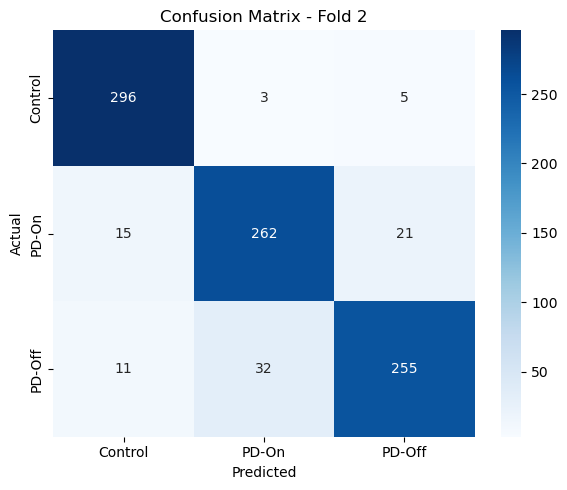

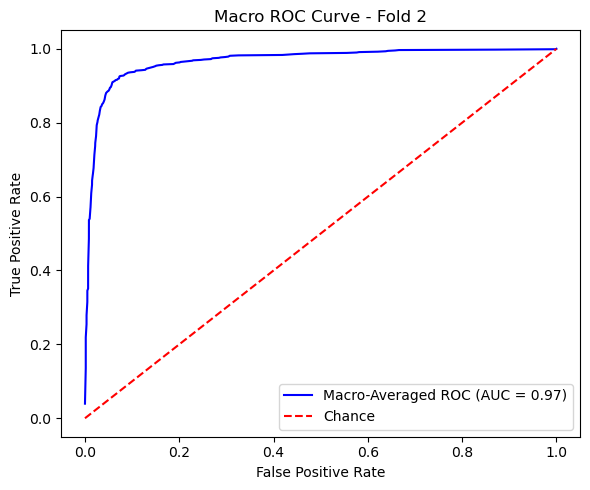


📁 Fold 3
Accuracy:  0.8888
Precision: 0.8883
Recall:    0.8884
F1-Score:  0.8882
AUC Score: 0.9675

Classification Report:
              precision    recall  f1-score   support

     Control       0.91      0.94      0.92       304
       PD-On       0.88      0.86      0.87       298
      PD-Off       0.87      0.87      0.87       297

    accuracy                           0.89       899
   macro avg       0.89      0.89      0.89       899
weighted avg       0.89      0.89      0.89       899



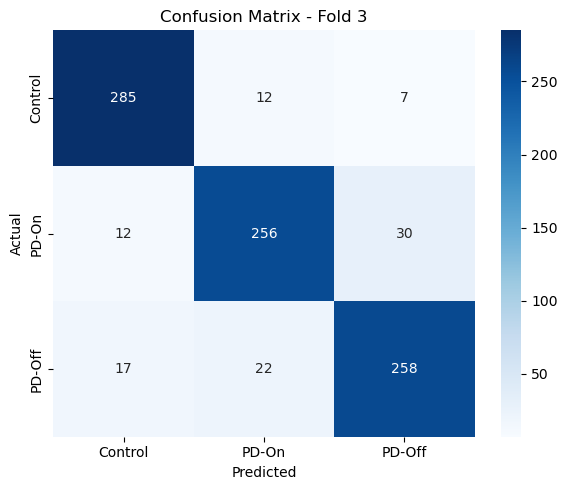

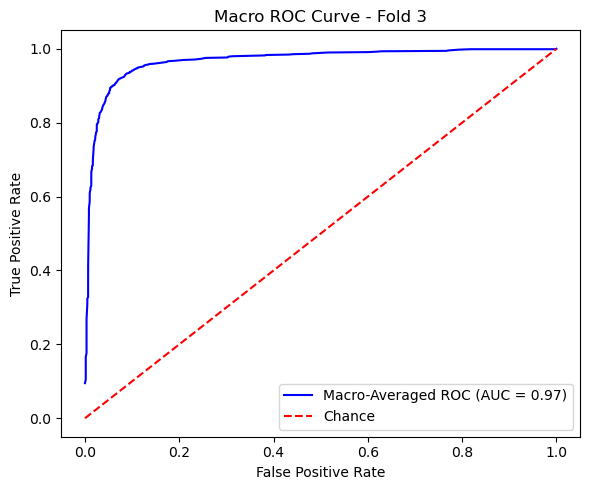


📁 Fold 4
Accuracy:  0.8676
Precision: 0.8671
Recall:    0.8671
F1-Score:  0.8667
AUC Score: 0.9616

Classification Report:
              precision    recall  f1-score   support

     Control       0.91      0.94      0.92       304
       PD-On       0.83      0.84      0.83       297
      PD-Off       0.87      0.82      0.84       298

    accuracy                           0.87       899
   macro avg       0.87      0.87      0.87       899
weighted avg       0.87      0.87      0.87       899



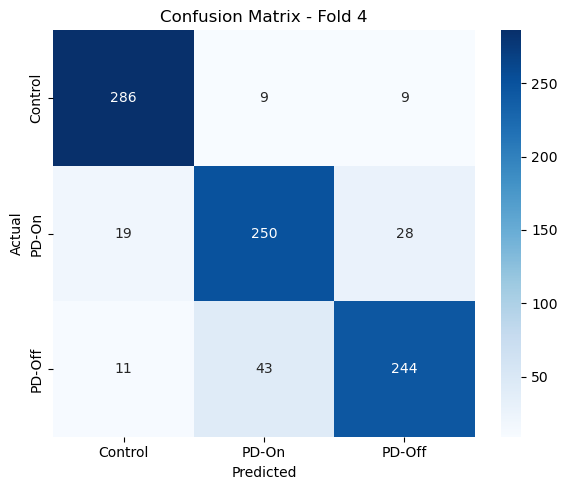

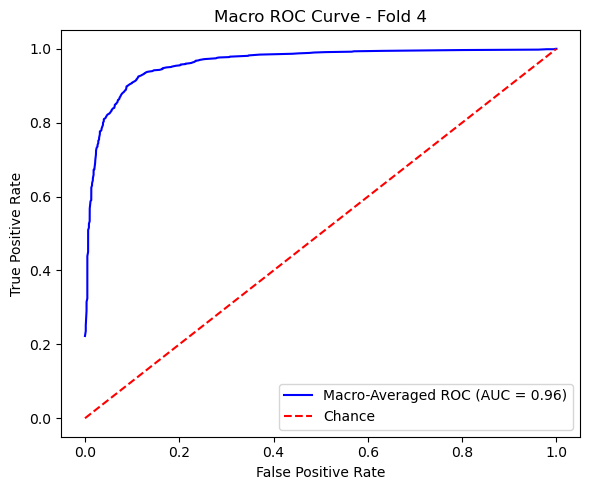


📁 Fold 5
Accuracy:  0.8966
Precision: 0.8961
Recall:    0.8962
F1-Score:  0.8961
AUC Score: 0.9661

Classification Report:
              precision    recall  f1-score   support

     Control       0.92      0.94      0.93       304
       PD-On       0.89      0.88      0.88       297
      PD-Off       0.88      0.87      0.87       298

    accuracy                           0.90       899
   macro avg       0.90      0.90      0.90       899
weighted avg       0.90      0.90      0.90       899



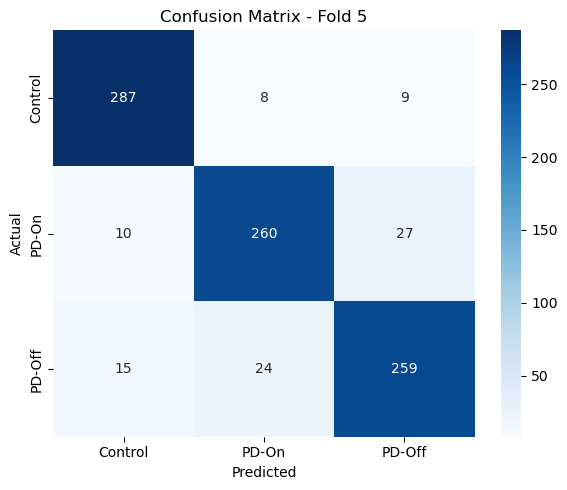

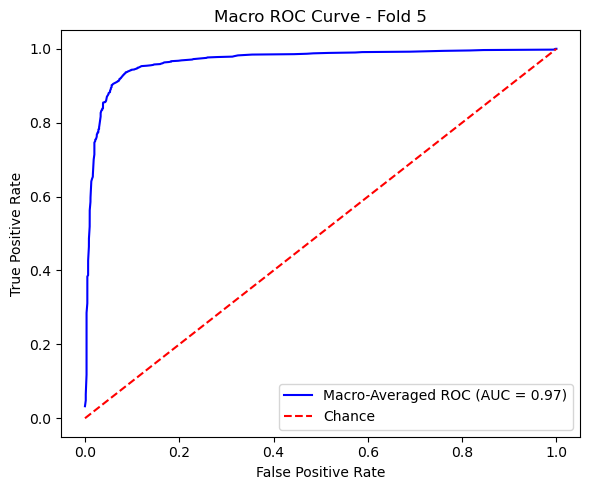


📊 Overall Cross-Validation Summary:
Mean Accuracy : 0.8875
Mean Precision: 0.8871
Mean Recall   : 0.8871
Mean F1       : 0.8868
Mean Auc      : 0.9631


In [66]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

# Assuming X and y have been processed and are available
# Ensure y is a 1D NumPy array if it’s a pandas series or dataframe
if isinstance(y, pd.Series):
    y = y.values
elif isinstance(y, pd.DataFrame):
    y = y.squeeze().values

# 🎯 Class names
class_names = ['Control', 'PD-On', 'PD-Off']
n_classes = len(class_names)

# ⚙️ Cross-Validation Setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 🧪 Metrics tracking
all_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "auc": []
}

# 🔄 Fold Loop
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n📁 Fold {fold}")
    
    # Splitting data into training and test sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # ⚖️ Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 🌳 SVM Model (with probability estimation for multi-class)
    model = SVC(
        kernel='linear',  # Using linear kernel for simplicity, can be adjusted
        C=1,  # Regularization parameter
        class_weight='balanced',  # Handle class imbalance
        random_state=42,
        probability=True,  # Enable probability estimates
        verbose=False  # Disable verbose output
    )
    model.fit(X_train_scaled, y_train)
    
    # Make predictions and probabilities
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)
    
    # 📈 Metrics
    acc = np.mean(y_pred == y_test)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))  # Binarize for multi-class ROC
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

    # 📊 Append
    all_metrics["accuracy"].append(acc)
    all_metrics["precision"].append(prec)
    all_metrics["recall"].append(rec)
    all_metrics["f1"].append(f1)
    all_metrics["auc"].append(auc_score)

    # 🧾 Classification Report
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    
    # Display the classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # 🔵 Confusion Matrix (blue)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # 📉 ROC Curve (macro-averaged)
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    
    # Compute macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    plt.figure(figsize=(6, 5))
    plt.plot(all_fpr, mean_tpr, color='blue', label=f'Macro-Averaged ROC (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Macro ROC Curve - Fold {fold}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# 📊 Overall Summary
print("\n📊 Overall Cross-Validation Summary:")
for key in all_metrics:
    mean_val = np.mean(all_metrics[key])
    print(f"Mean {key.capitalize():<9}: {mean_val:.4f}")


## Step 4.3: Train Logistic Regression Classifier


📁 Fold 1
Accuracy:  0.8611
Precision: 0.8601
Recall:    0.8606
F1-Score:  0.8602
AUC Score: 0.9465

Classification Report:
              precision    recall  f1-score   support

     Control       0.90      0.93      0.92       304
       PD-On       0.84      0.82      0.83       298
      PD-Off       0.83      0.83      0.83       298

    accuracy                           0.86       900
   macro avg       0.86      0.86      0.86       900
weighted avg       0.86      0.86      0.86       900



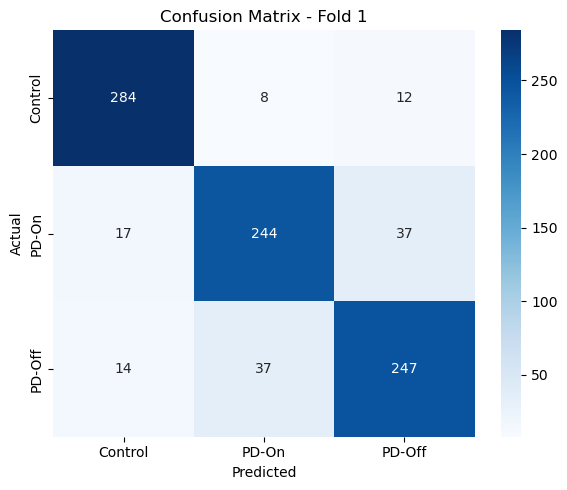

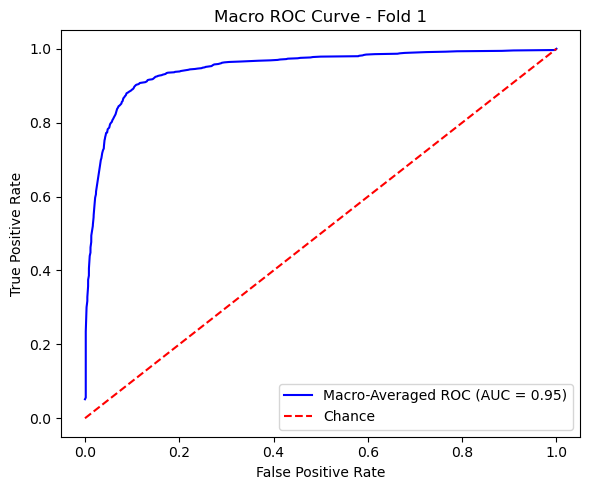


📁 Fold 2
Accuracy:  0.8822
Precision: 0.8815
Recall:    0.8817
F1-Score:  0.8810
AUC Score: 0.9618

Classification Report:
              precision    recall  f1-score   support

     Control       0.90      0.96      0.93       304
       PD-On       0.87      0.86      0.86       298
      PD-Off       0.88      0.83      0.85       298

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



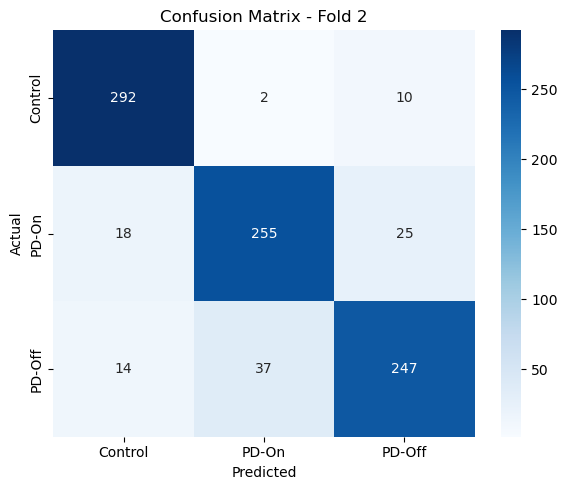

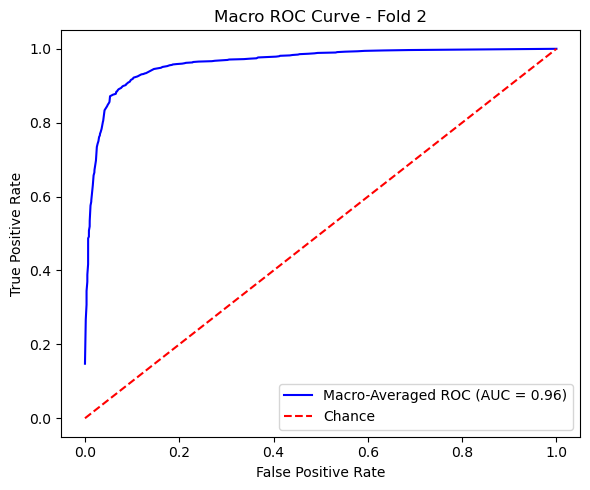


📁 Fold 3
Accuracy:  0.8776
Precision: 0.8770
Recall:    0.8770
F1-Score:  0.8763
AUC Score: 0.9607

Classification Report:
              precision    recall  f1-score   support

     Control       0.89      0.96      0.92       304
       PD-On       0.88      0.85      0.86       298
      PD-Off       0.87      0.82      0.84       297

    accuracy                           0.88       899
   macro avg       0.88      0.88      0.88       899
weighted avg       0.88      0.88      0.88       899



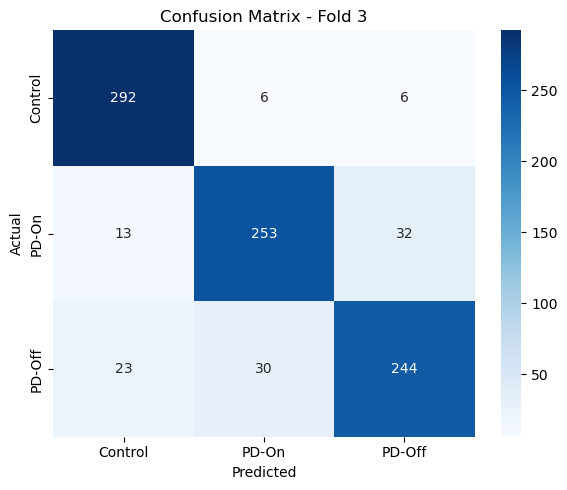

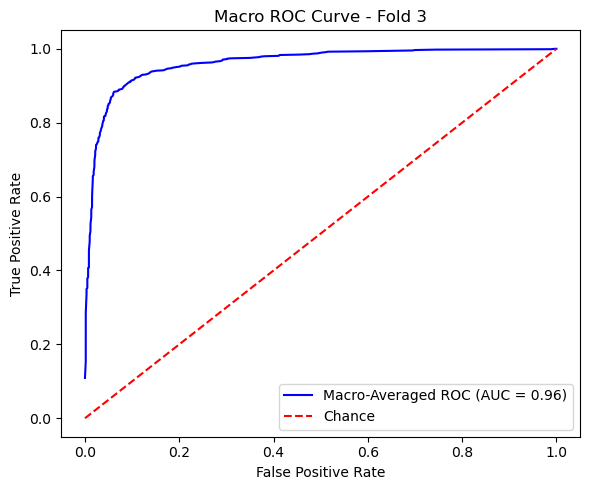


📁 Fold 4
Accuracy:  0.8621
Precision: 0.8610
Recall:    0.8615
F1-Score:  0.8607
AUC Score: 0.9542

Classification Report:
              precision    recall  f1-score   support

     Control       0.89      0.94      0.92       304
       PD-On       0.85      0.80      0.83       297
      PD-Off       0.85      0.84      0.84       298

    accuracy                           0.86       899
   macro avg       0.86      0.86      0.86       899
weighted avg       0.86      0.86      0.86       899



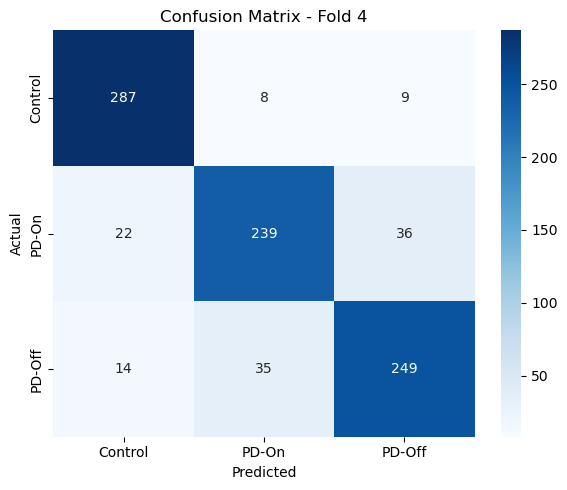

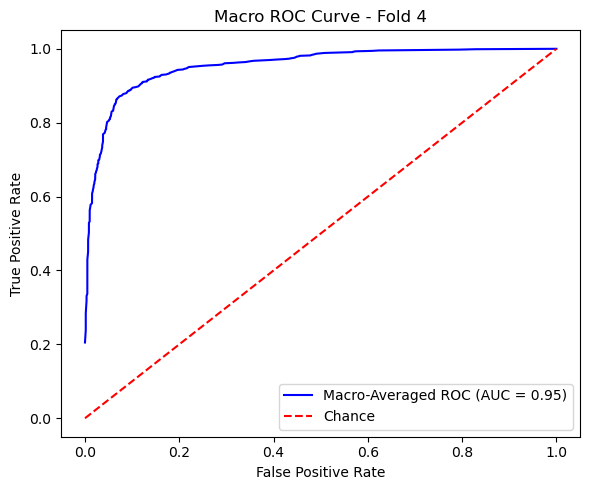


📁 Fold 5
Accuracy:  0.8743
Precision: 0.8741
Recall:    0.8738
F1-Score:  0.8734
AUC Score: 0.9590

Classification Report:
              precision    recall  f1-score   support

     Control       0.89      0.94      0.92       304
       PD-On       0.88      0.82      0.85       297
      PD-Off       0.84      0.85      0.85       298

    accuracy                           0.87       899
   macro avg       0.87      0.87      0.87       899
weighted avg       0.87      0.87      0.87       899



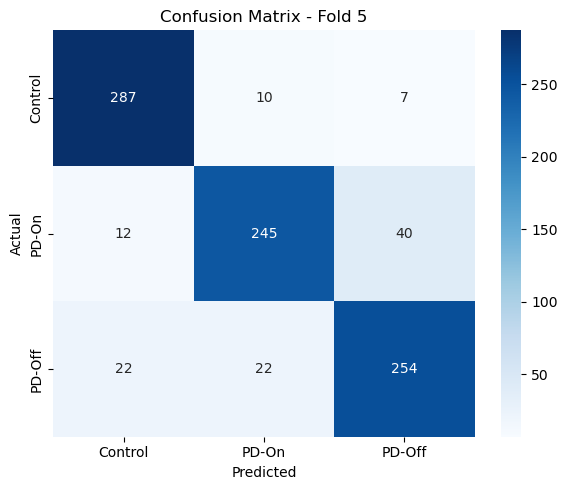

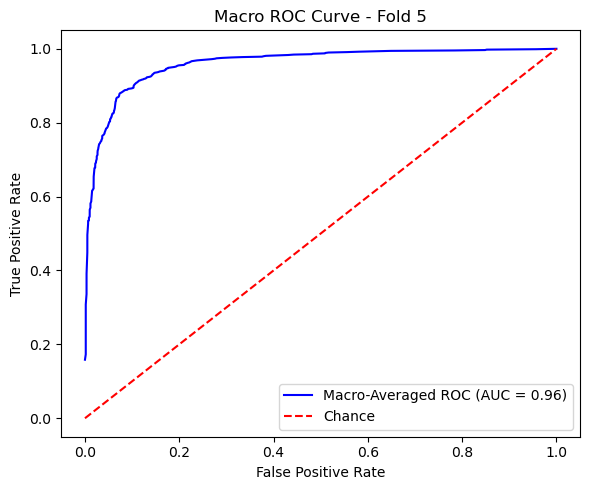


📊 Overall Cross-Validation Summary:
Mean Accuracy : 0.8715
Mean Precision: 0.8707
Mean Recall   : 0.8709
Mean F1       : 0.8703
Mean Auc      : 0.9564


In [67]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

# Assuming X and y have been processed and are available
# Ensure y is a 1D NumPy array if it’s a pandas series or dataframe
if isinstance(y, pd.Series):
    y = y.values
elif isinstance(y, pd.DataFrame):
    y = y.squeeze().values

# 🎯 Class names
class_names = ['Control', 'PD-On', 'PD-Off']
n_classes = len(class_names)

# ⚙️ Cross-Validation Setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 🧪 Metrics tracking
all_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "auc": []
}

# 🔄 Fold Loop
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n📁 Fold {fold}")
    
    # Splitting data into training and test sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # ⚖️ Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 🌳 Logistic Regression Model
    model = LogisticRegression(
        max_iter=1000,  # Ensure convergence
        class_weight='balanced',  # Handle class imbalance
        random_state=42,
        multi_class='ovr',  # One-vs-rest for multi-class classification
        solver='liblinear'  # Using liblinear solver for small datasets
    )
    model.fit(X_train_scaled, y_train)
    
    # Make predictions and probabilities
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)
    
    # 📈 Metrics
    acc = np.mean(y_pred == y_test)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))  # Binarize for multi-class ROC
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

    # 📊 Append
    all_metrics["accuracy"].append(acc)
    all_metrics["precision"].append(prec)
    all_metrics["recall"].append(rec)
    all_metrics["f1"].append(f1)
    all_metrics["auc"].append(auc_score)

    # 🧾 Classification Report
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    
    # Display the classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # 🔵 Confusion Matrix (blue)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # 📉 ROC Curve (macro-averaged)
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    
    # Compute macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    plt.figure(figsize=(6, 5))
    plt.plot(all_fpr, mean_tpr, color='blue', label=f'Macro-Averaged ROC (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Macro ROC Curve - Fold {fold}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# 📊 Overall Summary
print("\n📊 Overall Cross-Validation Summary:")
for key in all_metrics:
    mean_val = np.mean(all_metrics[key])
    print(f"Mean {key.capitalize():<9}: {mean_val:.4f}")


## **Transformer Model**

In [96]:
!pip install torch torchvision

In [97]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

**BLOCK 1: Preprocessing and DataLoader**

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Entire dataset (X and y)
X = np.concatenate([X_train, X_test], axis=0)  # shape (4497, 160)
y = np.concatenate([y_train, y_test], axis=0)  # shape (4497,)

X = X.astype(np.float32)
y = y.astype(np.int64)

# K-Fold cross-validation will split this
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store all folds' loaders, weights, scalers
fold_data = []

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"📂 Preparing Fold {fold_idx}...")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Standardize using only training set
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_val_std = scaler.transform(X_val)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_std, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # Compute class weights for this fold
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    # Create DataLoaders
    batch_size = 64
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

    fold_data.append({
        'train_loader': train_loader,
        'val_loader': val_loader,
        'class_weights': class_weights_tensor,
        'scaler': scaler,
        'X_val': X_val_std,
        'y_val': y_val,
    })



📂 Preparing Fold 1...
📂 Preparing Fold 2...
📂 Preparing Fold 3...
📂 Preparing Fold 4...
📂 Preparing Fold 5...


**BLOCK 2: Transformer Model Definition**

In [99]:
import torch
import torch.nn as nn

class EEGTransformer(nn.Module):
    def __init__(self, input_dim=160, num_classes=3, embed_dim=128, num_heads=4, num_layers=2, dropout=0.3):
        super().__init__()
        
        self.embedding = nn.Linear(input_dim, embed_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            dropout=dropout,
            batch_first=True
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (B, input_dim)
        x = self.embedding(x).unsqueeze(1)  # (B, 1, embed_dim)
        x = self.transformer_encoder(x)     # (B, 1, embed_dim)
        x = x.squeeze(1)                    # (B, embed_dim)
        return self.classifier(x)           # (B, num_classes)


**BLOCK 3: Training Setup**

In [100]:
from transformers import get_cosine_schedule_with_warmup
import torch.optim as optim
import torch.nn as nn

def initialize_training_components(input_dim, num_classes, class_weights_tensor, train_loader, epochs=40, lr=5e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model
    model = EEGTransformer(input_dim=input_dim, num_classes=num_classes).to(device)

    # Loss function with class weights
    loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Cosine LR scheduler with warmup
    total_steps = len(train_loader) * epochs
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),  # 10% warmup by default
        num_training_steps=total_steps
    )

    return model, loss_fn, optimizer, scheduler, device


**BLOCK 4: Training and Evaluation Loop with tqdm**

In [101]:
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def train_one_epoch(model, loader, optimizer, loss_fn, scheduler, device):
    model.train()
    total_loss = 0
    correct, total = 0, 0
    loop = tqdm(loader, desc="Train", leave=False)
    
    for xb, yb in loop:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        correct += (preds.argmax(1) == yb).sum().item()
        total += yb.size(0)

        loop.set_postfix(loss=loss.item(), acc=correct / total)

    avg_loss = total_loss / len(loader)
    avg_acc = correct / total
    return avg_loss, avg_acc

def evaluate(model, loader, device, return_preds=False, show_plot=True):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = logits.argmax(1).cpu().numpy()

            y_prob.extend(probs)
            y_pred.extend(preds)
            y_true.extend(yb.numpy())

    if return_preds:
        return y_true, y_pred, y_prob

    # Report and Confusion Matrix
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["CTL", "PD-On", "PD-Off"], digits=4))

    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=["CTL", "PD-On", "PD-Off"], columns=["CTL", "PD-On", "PD-Off"])

    plt.figure(figsize=(6, 5))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


**BLOCK 5: Training Loop**


📁 ===== Fold 1 =====

🌟 Epoch 1/40 — Fold 1


✅ Train Loss: 1.0672 | Train Acc: 0.4312

🌟 Epoch 2/40 — Fold 1


✅ Train Loss: 0.7986 | Train Acc: 0.6611

🌟 Epoch 3/40 — Fold 1


✅ Train Loss: 0.5083 | Train Acc: 0.7973

🌟 Epoch 4/40 — Fold 1


✅ Train Loss: 0.3579 | Train Acc: 0.8604

🌟 Epoch 5/40 — Fold 1


✅ Train Loss: 0.2863 | Train Acc: 0.8944

🌟 Epoch 6/40 — Fold 1


✅ Train Loss: 0.1989 | Train Acc: 0.9294

🌟 Epoch 7/40 — Fold 1


✅ Train Loss: 0.1355 | Train Acc: 0.9511

🌟 Epoch 8/40 — Fold 1


✅ Train Loss: 0.1356 | Train Acc: 0.9541

🌟 Epoch 9/40 — Fold 1


✅ Train Loss: 0.1229 | Train Acc: 0.9577

🌟 Epoch 10/40 — Fold 1


✅ Train Loss: 0.1050 | Train Acc: 0.9639

🌟 Epoch 11/40 — Fold 1


✅ Train Loss: 0.1020 | Train Acc: 0.9650

🌟 Epoch 12/40 — Fold 1


✅ Train Loss: 0.0706 | Train Acc: 0.9772

🌟 Epoch 13/40 — Fold 1


✅ Train Loss: 0.0613 | Train Acc: 0.9817

🌟 Epoch 14/40 — Fold 1


✅ Train Loss: 0.0522 | Train Acc: 0.9833

🌟 Epoch 15/40 — Fold 1


✅ Train Loss: 0.0763 | Train Acc: 0.9755

🌟 Epoch 16/40 — Fold 1


✅ Train Loss: 0.0469 | Train Acc: 0.9853

🌟 Epoch 17/40 — Fold 1


✅ Train Loss: 0.0330 | Train Acc: 0.9914

🌟 Epoch 18/40 — Fold 1


✅ Train Loss: 0.0277 | Train Acc: 0.9914

🌟 Epoch 19/40 — Fold 1


✅ Train Loss: 0.0400 | Train Acc: 0.9889

🌟 Epoch 20/40 — Fold 1


✅ Train Loss: 0.0150 | Train Acc: 0.9956

🌟 Epoch 21/40 — Fold 1


✅ Train Loss: 0.0345 | Train Acc: 0.9892

🌟 Epoch 22/40 — Fold 1


✅ Train Loss: 0.0143 | Train Acc: 0.9956

🌟 Epoch 23/40 — Fold 1


✅ Train Loss: 0.0136 | Train Acc: 0.9967

🌟 Epoch 24/40 — Fold 1


✅ Train Loss: 0.0094 | Train Acc: 0.9978

🌟 Epoch 25/40 — Fold 1


✅ Train Loss: 0.0072 | Train Acc: 0.9978

🌟 Epoch 26/40 — Fold 1


✅ Train Loss: 0.0089 | Train Acc: 0.9969

🌟 Epoch 27/40 — Fold 1


✅ Train Loss: 0.0079 | Train Acc: 0.9978

🌟 Epoch 28/40 — Fold 1


✅ Train Loss: 0.0119 | Train Acc: 0.9972

🌟 Epoch 29/40 — Fold 1


✅ Train Loss: 0.0059 | Train Acc: 0.9986

🌟 Epoch 30/40 — Fold 1


✅ Train Loss: 0.0056 | Train Acc: 0.9978

🌟 Epoch 31/40 — Fold 1


✅ Train Loss: 0.0054 | Train Acc: 0.9983

🌟 Epoch 32/40 — Fold 1


✅ Train Loss: 0.0056 | Train Acc: 0.9986

🌟 Epoch 33/40 — Fold 1


✅ Train Loss: 0.0047 | Train Acc: 0.9989

🌟 Epoch 34/40 — Fold 1


✅ Train Loss: 0.0032 | Train Acc: 0.9986

🌟 Epoch 35/40 — Fold 1


✅ Train Loss: 0.0033 | Train Acc: 0.9994

🌟 Epoch 36/40 — Fold 1


✅ Train Loss: 0.0030 | Train Acc: 0.9992

🌟 Epoch 37/40 — Fold 1


✅ Train Loss: 0.0019 | Train Acc: 0.9997

🌟 Epoch 38/40 — Fold 1


✅ Train Loss: 0.0015 | Train Acc: 1.0000

🌟 Epoch 39/40 — Fold 1


✅ Train Loss: 0.0022 | Train Acc: 0.9994

🌟 Epoch 40/40 — Fold 1


✅ Train Loss: 0.0055 | Train Acc: 0.9986

📊 Classification Report:
              precision    recall  f1-score   support

         CTL     0.9935    1.0000    0.9967       304
       PD-On     0.9764    0.9732    0.9748       298
      PD-Off     0.9731    0.9698    0.9714       298

    accuracy                         0.9811       900
   macro avg     0.9810    0.9810    0.9810       900
weighted avg     0.9811    0.9811    0.9811       900



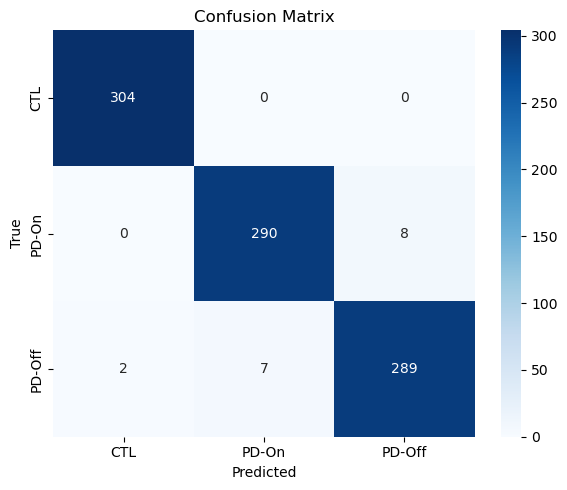

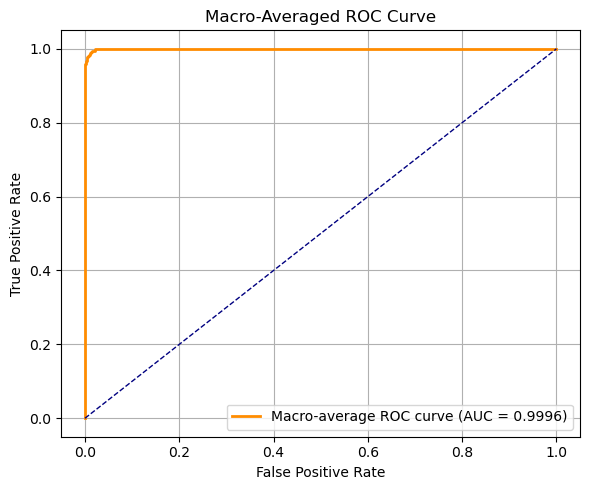


📁 ===== Fold 2 =====

🌟 Epoch 1/40 — Fold 2


✅ Train Loss: 1.0227 | Train Acc: 0.4743

🌟 Epoch 2/40 — Fold 2


✅ Train Loss: 0.7470 | Train Acc: 0.6850

🌟 Epoch 3/40 — Fold 2


✅ Train Loss: 0.4745 | Train Acc: 0.8190

🌟 Epoch 4/40 — Fold 2


✅ Train Loss: 0.3532 | Train Acc: 0.8649

🌟 Epoch 5/40 — Fold 2


✅ Train Loss: 0.2834 | Train Acc: 0.8896

🌟 Epoch 6/40 — Fold 2


✅ Train Loss: 0.2611 | Train Acc: 0.9021

🌟 Epoch 7/40 — Fold 2


✅ Train Loss: 0.1916 | Train Acc: 0.9319

🌟 Epoch 8/40 — Fold 2


✅ Train Loss: 0.1680 | Train Acc: 0.9388

🌟 Epoch 9/40 — Fold 2


✅ Train Loss: 0.1541 | Train Acc: 0.9433

🌟 Epoch 10/40 — Fold 2


✅ Train Loss: 0.1364 | Train Acc: 0.9502

🌟 Epoch 11/40 — Fold 2


✅ Train Loss: 0.1059 | Train Acc: 0.9664

🌟 Epoch 12/40 — Fold 2


✅ Train Loss: 0.1090 | Train Acc: 0.9625

🌟 Epoch 13/40 — Fold 2


✅ Train Loss: 0.0837 | Train Acc: 0.9697

🌟 Epoch 14/40 — Fold 2


✅ Train Loss: 0.0800 | Train Acc: 0.9728

🌟 Epoch 15/40 — Fold 2


✅ Train Loss: 0.0481 | Train Acc: 0.9836

🌟 Epoch 16/40 — Fold 2


✅ Train Loss: 0.0586 | Train Acc: 0.9803

🌟 Epoch 17/40 — Fold 2


✅ Train Loss: 0.0392 | Train Acc: 0.9867

🌟 Epoch 18/40 — Fold 2


✅ Train Loss: 0.0374 | Train Acc: 0.9872

🌟 Epoch 19/40 — Fold 2


✅ Train Loss: 0.0465 | Train Acc: 0.9875

🌟 Epoch 20/40 — Fold 2


✅ Train Loss: 0.0313 | Train Acc: 0.9897

🌟 Epoch 21/40 — Fold 2


✅ Train Loss: 0.0228 | Train Acc: 0.9928

🌟 Epoch 22/40 — Fold 2


✅ Train Loss: 0.0247 | Train Acc: 0.9908

🌟 Epoch 23/40 — Fold 2


✅ Train Loss: 0.0254 | Train Acc: 0.9905

🌟 Epoch 24/40 — Fold 2


✅ Train Loss: 0.0305 | Train Acc: 0.9892

🌟 Epoch 25/40 — Fold 2


✅ Train Loss: 0.0154 | Train Acc: 0.9950

🌟 Epoch 26/40 — Fold 2


✅ Train Loss: 0.0081 | Train Acc: 0.9975

🌟 Epoch 27/40 — Fold 2


✅ Train Loss: 0.0082 | Train Acc: 0.9975

🌟 Epoch 28/40 — Fold 2


✅ Train Loss: 0.0056 | Train Acc: 0.9986

🌟 Epoch 29/40 — Fold 2


✅ Train Loss: 0.0064 | Train Acc: 0.9981

🌟 Epoch 30/40 — Fold 2


✅ Train Loss: 0.0108 | Train Acc: 0.9989

🌟 Epoch 31/40 — Fold 2


✅ Train Loss: 0.0138 | Train Acc: 0.9964

🌟 Epoch 32/40 — Fold 2


✅ Train Loss: 0.0064 | Train Acc: 0.9986

🌟 Epoch 33/40 — Fold 2


✅ Train Loss: 0.0029 | Train Acc: 0.9997

🌟 Epoch 34/40 — Fold 2


✅ Train Loss: 0.0052 | Train Acc: 0.9992

🌟 Epoch 35/40 — Fold 2


✅ Train Loss: 0.0021 | Train Acc: 1.0000

🌟 Epoch 36/40 — Fold 2


✅ Train Loss: 0.0027 | Train Acc: 0.9997

🌟 Epoch 37/40 — Fold 2


✅ Train Loss: 0.0033 | Train Acc: 0.9994

🌟 Epoch 38/40 — Fold 2


✅ Train Loss: 0.0042 | Train Acc: 0.9986

🌟 Epoch 39/40 — Fold 2


✅ Train Loss: 0.0017 | Train Acc: 1.0000

🌟 Epoch 40/40 — Fold 2


✅ Train Loss: 0.0032 | Train Acc: 0.9992

📊 Classification Report:
              precision    recall  f1-score   support

         CTL     1.0000    0.9967    0.9984       304
       PD-On     0.9900    0.9933    0.9916       298
      PD-Off     0.9899    0.9899    0.9899       298

    accuracy                         0.9933       900
   macro avg     0.9933    0.9933    0.9933       900
weighted avg     0.9933    0.9933    0.9933       900



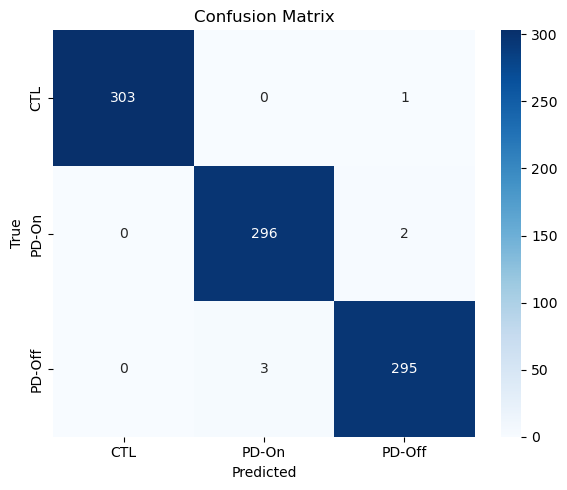

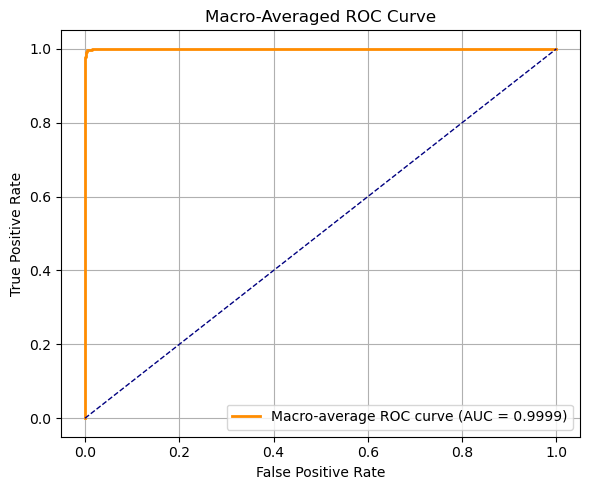


📁 ===== Fold 3 =====

🌟 Epoch 1/40 — Fold 3


✅ Train Loss: 1.0195 | Train Acc: 0.4903

🌟 Epoch 2/40 — Fold 3


✅ Train Loss: 0.7553 | Train Acc: 0.6762

🌟 Epoch 3/40 — Fold 3


✅ Train Loss: 0.4818 | Train Acc: 0.8029

🌟 Epoch 4/40 — Fold 3


✅ Train Loss: 0.3376 | Train Acc: 0.8646

🌟 Epoch 5/40 — Fold 3


✅ Train Loss: 0.2948 | Train Acc: 0.8852

🌟 Epoch 6/40 — Fold 3


✅ Train Loss: 0.2185 | Train Acc: 0.9194

🌟 Epoch 7/40 — Fold 3


✅ Train Loss: 0.1839 | Train Acc: 0.9294

🌟 Epoch 8/40 — Fold 3


✅ Train Loss: 0.1490 | Train Acc: 0.9461

🌟 Epoch 9/40 — Fold 3


✅ Train Loss: 0.1206 | Train Acc: 0.9608

🌟 Epoch 10/40 — Fold 3


✅ Train Loss: 0.1148 | Train Acc: 0.9619

🌟 Epoch 11/40 — Fold 3


✅ Train Loss: 0.0849 | Train Acc: 0.9722

🌟 Epoch 12/40 — Fold 3


✅ Train Loss: 0.0705 | Train Acc: 0.9758

🌟 Epoch 13/40 — Fold 3


✅ Train Loss: 0.0876 | Train Acc: 0.9703

🌟 Epoch 14/40 — Fold 3


✅ Train Loss: 0.0733 | Train Acc: 0.9753

🌟 Epoch 15/40 — Fold 3


✅ Train Loss: 0.0493 | Train Acc: 0.9842

🌟 Epoch 16/40 — Fold 3


✅ Train Loss: 0.0344 | Train Acc: 0.9900

🌟 Epoch 17/40 — Fold 3


✅ Train Loss: 0.0380 | Train Acc: 0.9880

🌟 Epoch 18/40 — Fold 3


✅ Train Loss: 0.0447 | Train Acc: 0.9858

🌟 Epoch 19/40 — Fold 3


✅ Train Loss: 0.0314 | Train Acc: 0.9892

🌟 Epoch 20/40 — Fold 3


✅ Train Loss: 0.0164 | Train Acc: 0.9950

🌟 Epoch 21/40 — Fold 3


✅ Train Loss: 0.0325 | Train Acc: 0.9911

🌟 Epoch 22/40 — Fold 3


✅ Train Loss: 0.0244 | Train Acc: 0.9933

🌟 Epoch 23/40 — Fold 3


✅ Train Loss: 0.0123 | Train Acc: 0.9967

🌟 Epoch 24/40 — Fold 3


✅ Train Loss: 0.0148 | Train Acc: 0.9953

🌟 Epoch 25/40 — Fold 3


✅ Train Loss: 0.0112 | Train Acc: 0.9969

🌟 Epoch 26/40 — Fold 3


✅ Train Loss: 0.0126 | Train Acc: 0.9964

🌟 Epoch 27/40 — Fold 3


✅ Train Loss: 0.0098 | Train Acc: 0.9964

🌟 Epoch 28/40 — Fold 3


✅ Train Loss: 0.0126 | Train Acc: 0.9958

🌟 Epoch 29/40 — Fold 3


✅ Train Loss: 0.0117 | Train Acc: 0.9961

🌟 Epoch 30/40 — Fold 3


✅ Train Loss: 0.0033 | Train Acc: 0.9992

🌟 Epoch 31/40 — Fold 3


✅ Train Loss: 0.0033 | Train Acc: 0.9994

🌟 Epoch 32/40 — Fold 3


✅ Train Loss: 0.0043 | Train Acc: 0.9989

🌟 Epoch 33/40 — Fold 3


✅ Train Loss: 0.0056 | Train Acc: 0.9989

🌟 Epoch 34/40 — Fold 3


✅ Train Loss: 0.0030 | Train Acc: 0.9994

🌟 Epoch 35/40 — Fold 3


✅ Train Loss: 0.0027 | Train Acc: 0.9994

🌟 Epoch 36/40 — Fold 3


✅ Train Loss: 0.0027 | Train Acc: 0.9992

🌟 Epoch 37/40 — Fold 3


✅ Train Loss: 0.0021 | Train Acc: 0.9994

🌟 Epoch 38/40 — Fold 3


✅ Train Loss: 0.0022 | Train Acc: 0.9994

🌟 Epoch 39/40 — Fold 3


✅ Train Loss: 0.0035 | Train Acc: 0.9992

🌟 Epoch 40/40 — Fold 3


✅ Train Loss: 0.0028 | Train Acc: 0.9992

📊 Classification Report:
              precision    recall  f1-score   support

         CTL     1.0000    0.9901    0.9950       304
       PD-On     0.9832    0.9832    0.9832       298
      PD-Off     0.9733    0.9832    0.9782       297

    accuracy                         0.9855       899
   macro avg     0.9855    0.9855    0.9855       899
weighted avg     0.9856    0.9855    0.9856       899



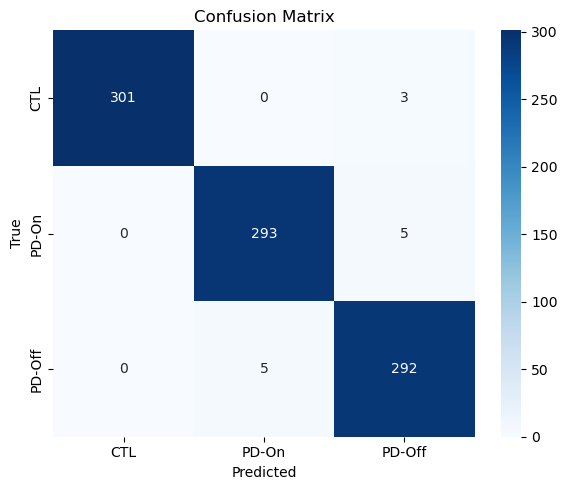

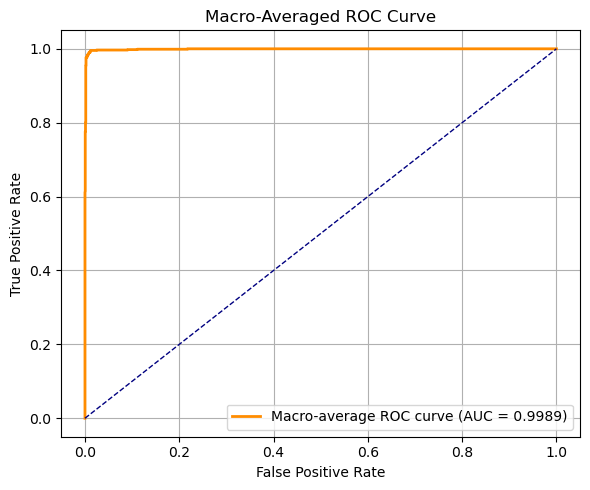


📁 ===== Fold 4 =====

🌟 Epoch 1/40 — Fold 4


✅ Train Loss: 1.0532 | Train Acc: 0.4397

🌟 Epoch 2/40 — Fold 4


✅ Train Loss: 0.7927 | Train Acc: 0.6681

🌟 Epoch 3/40 — Fold 4


✅ Train Loss: 0.4784 | Train Acc: 0.8155

🌟 Epoch 4/40 — Fold 4


✅ Train Loss: 0.3987 | Train Acc: 0.8488

🌟 Epoch 5/40 — Fold 4


✅ Train Loss: 0.2544 | Train Acc: 0.9052

🌟 Epoch 6/40 — Fold 4


✅ Train Loss: 0.2426 | Train Acc: 0.9158

🌟 Epoch 7/40 — Fold 4


✅ Train Loss: 0.1663 | Train Acc: 0.9441

🌟 Epoch 8/40 — Fold 4


✅ Train Loss: 0.1728 | Train Acc: 0.9369

🌟 Epoch 9/40 — Fold 4


✅ Train Loss: 0.1846 | Train Acc: 0.9330

🌟 Epoch 10/40 — Fold 4


✅ Train Loss: 0.1237 | Train Acc: 0.9583

🌟 Epoch 11/40 — Fold 4


✅ Train Loss: 0.0964 | Train Acc: 0.9691

🌟 Epoch 12/40 — Fold 4


✅ Train Loss: 0.0804 | Train Acc: 0.9694

🌟 Epoch 13/40 — Fold 4


✅ Train Loss: 0.1109 | Train Acc: 0.9653

🌟 Epoch 14/40 — Fold 4


✅ Train Loss: 0.0484 | Train Acc: 0.9844

🌟 Epoch 15/40 — Fold 4


✅ Train Loss: 0.0547 | Train Acc: 0.9833

🌟 Epoch 16/40 — Fold 4


✅ Train Loss: 0.0410 | Train Acc: 0.9878

🌟 Epoch 17/40 — Fold 4


✅ Train Loss: 0.0533 | Train Acc: 0.9800

🌟 Epoch 18/40 — Fold 4


✅ Train Loss: 0.0237 | Train Acc: 0.9908

🌟 Epoch 19/40 — Fold 4


✅ Train Loss: 0.0230 | Train Acc: 0.9933

🌟 Epoch 20/40 — Fold 4


✅ Train Loss: 0.0686 | Train Acc: 0.9794

🌟 Epoch 21/40 — Fold 4


✅ Train Loss: 0.0349 | Train Acc: 0.9880

🌟 Epoch 22/40 — Fold 4


✅ Train Loss: 0.0190 | Train Acc: 0.9936

🌟 Epoch 23/40 — Fold 4


✅ Train Loss: 0.0197 | Train Acc: 0.9947

🌟 Epoch 24/40 — Fold 4


✅ Train Loss: 0.0212 | Train Acc: 0.9931

🌟 Epoch 25/40 — Fold 4


✅ Train Loss: 0.0086 | Train Acc: 0.9969

🌟 Epoch 26/40 — Fold 4


✅ Train Loss: 0.0082 | Train Acc: 0.9975

🌟 Epoch 27/40 — Fold 4


✅ Train Loss: 0.0136 | Train Acc: 0.9950

🌟 Epoch 28/40 — Fold 4


✅ Train Loss: 0.0099 | Train Acc: 0.9969

🌟 Epoch 29/40 — Fold 4


✅ Train Loss: 0.0054 | Train Acc: 0.9986

🌟 Epoch 30/40 — Fold 4


✅ Train Loss: 0.0085 | Train Acc: 0.9981

🌟 Epoch 31/40 — Fold 4


✅ Train Loss: 0.0029 | Train Acc: 0.9994

🌟 Epoch 32/40 — Fold 4


✅ Train Loss: 0.0037 | Train Acc: 0.9986

🌟 Epoch 33/40 — Fold 4


✅ Train Loss: 0.0019 | Train Acc: 0.9997

🌟 Epoch 34/40 — Fold 4


✅ Train Loss: 0.0032 | Train Acc: 0.9994

🌟 Epoch 35/40 — Fold 4


✅ Train Loss: 0.0037 | Train Acc: 0.9981

🌟 Epoch 36/40 — Fold 4


✅ Train Loss: 0.0026 | Train Acc: 0.9997

🌟 Epoch 37/40 — Fold 4


✅ Train Loss: 0.0019 | Train Acc: 0.9997

🌟 Epoch 38/40 — Fold 4


✅ Train Loss: 0.0028 | Train Acc: 0.9992

🌟 Epoch 39/40 — Fold 4


✅ Train Loss: 0.0029 | Train Acc: 0.9989

🌟 Epoch 40/40 — Fold 4


✅ Train Loss: 0.0030 | Train Acc: 0.9992

📊 Classification Report:
              precision    recall  f1-score   support

         CTL     1.0000    0.9934    0.9967       304
       PD-On     0.9898    0.9832    0.9865       297
      PD-Off     0.9801    0.9933    0.9867       298

    accuracy                         0.9900       899
   macro avg     0.9900    0.9900    0.9900       899
weighted avg     0.9901    0.9900    0.9900       899



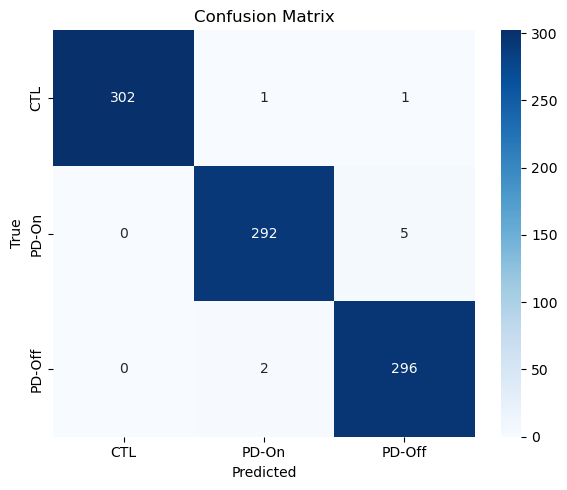

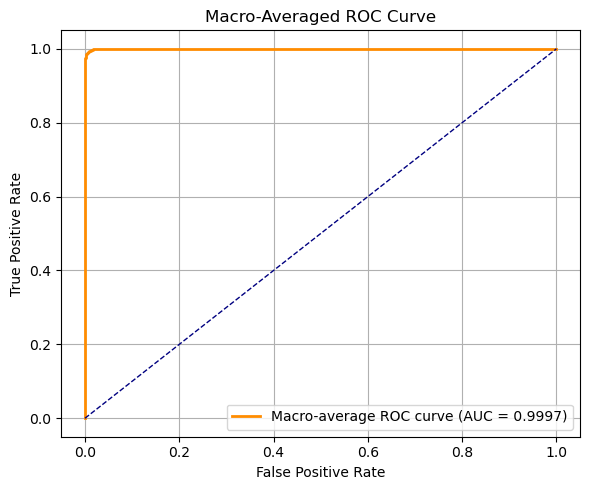


📁 ===== Fold 5 =====

🌟 Epoch 1/40 — Fold 5


✅ Train Loss: 1.0442 | Train Acc: 0.4497

🌟 Epoch 2/40 — Fold 5


✅ Train Loss: 0.7855 | Train Acc: 0.6598

🌟 Epoch 3/40 — Fold 5


✅ Train Loss: 0.5024 | Train Acc: 0.7899

🌟 Epoch 4/40 — Fold 5


✅ Train Loss: 0.3627 | Train Acc: 0.8574

🌟 Epoch 5/40 — Fold 5


✅ Train Loss: 0.2577 | Train Acc: 0.9061

🌟 Epoch 6/40 — Fold 5


✅ Train Loss: 0.2264 | Train Acc: 0.9152

🌟 Epoch 7/40 — Fold 5


✅ Train Loss: 0.1477 | Train Acc: 0.9503

🌟 Epoch 8/40 — Fold 5


✅ Train Loss: 0.1325 | Train Acc: 0.9530

🌟 Epoch 9/40 — Fold 5


✅ Train Loss: 0.1207 | Train Acc: 0.9578

🌟 Epoch 10/40 — Fold 5


✅ Train Loss: 0.0844 | Train Acc: 0.9705

🌟 Epoch 11/40 — Fold 5


✅ Train Loss: 0.0725 | Train Acc: 0.9758

🌟 Epoch 12/40 — Fold 5


✅ Train Loss: 0.0781 | Train Acc: 0.9730

🌟 Epoch 13/40 — Fold 5


✅ Train Loss: 0.0722 | Train Acc: 0.9775

🌟 Epoch 14/40 — Fold 5


✅ Train Loss: 0.0509 | Train Acc: 0.9855

🌟 Epoch 15/40 — Fold 5


✅ Train Loss: 0.0695 | Train Acc: 0.9761

🌟 Epoch 16/40 — Fold 5


✅ Train Loss: 0.0590 | Train Acc: 0.9808

🌟 Epoch 17/40 — Fold 5


✅ Train Loss: 0.0448 | Train Acc: 0.9867

🌟 Epoch 18/40 — Fold 5


✅ Train Loss: 0.0376 | Train Acc: 0.9878

🌟 Epoch 19/40 — Fold 5


✅ Train Loss: 0.0335 | Train Acc: 0.9908

🌟 Epoch 20/40 — Fold 5


✅ Train Loss: 0.0164 | Train Acc: 0.9953

🌟 Epoch 21/40 — Fold 5


✅ Train Loss: 0.0198 | Train Acc: 0.9939

🌟 Epoch 22/40 — Fold 5


✅ Train Loss: 0.0183 | Train Acc: 0.9942

🌟 Epoch 23/40 — Fold 5


✅ Train Loss: 0.0097 | Train Acc: 0.9978

🌟 Epoch 24/40 — Fold 5


✅ Train Loss: 0.0081 | Train Acc: 0.9975

🌟 Epoch 25/40 — Fold 5


✅ Train Loss: 0.0081 | Train Acc: 0.9975

🌟 Epoch 26/40 — Fold 5


✅ Train Loss: 0.0061 | Train Acc: 0.9983

🌟 Epoch 27/40 — Fold 5


✅ Train Loss: 0.0064 | Train Acc: 0.9978

🌟 Epoch 28/40 — Fold 5


✅ Train Loss: 0.0072 | Train Acc: 0.9978

🌟 Epoch 29/40 — Fold 5


✅ Train Loss: 0.0032 | Train Acc: 0.9989

🌟 Epoch 30/40 — Fold 5


✅ Train Loss: 0.0038 | Train Acc: 0.9989

🌟 Epoch 31/40 — Fold 5


✅ Train Loss: 0.0025 | Train Acc: 0.9992

🌟 Epoch 32/40 — Fold 5


✅ Train Loss: 0.0031 | Train Acc: 0.9994

🌟 Epoch 33/40 — Fold 5


✅ Train Loss: 0.0017 | Train Acc: 0.9997

🌟 Epoch 34/40 — Fold 5


✅ Train Loss: 0.0017 | Train Acc: 0.9994

🌟 Epoch 35/40 — Fold 5


✅ Train Loss: 0.0025 | Train Acc: 0.9992

🌟 Epoch 36/40 — Fold 5


✅ Train Loss: 0.0012 | Train Acc: 1.0000

🌟 Epoch 37/40 — Fold 5


✅ Train Loss: 0.0012 | Train Acc: 1.0000

🌟 Epoch 38/40 — Fold 5


✅ Train Loss: 0.0015 | Train Acc: 0.9997

🌟 Epoch 39/40 — Fold 5


✅ Train Loss: 0.0038 | Train Acc: 0.9986

🌟 Epoch 40/40 — Fold 5


✅ Train Loss: 0.0015 | Train Acc: 0.9997

📊 Classification Report:
              precision    recall  f1-score   support

         CTL     0.9708    0.9836    0.9771       304
       PD-On     0.9792    0.9495    0.9641       297
      PD-Off     0.9538    0.9698    0.9617       298

    accuracy                         0.9677       899
   macro avg     0.9679    0.9676    0.9677       899
weighted avg     0.9679    0.9677    0.9677       899



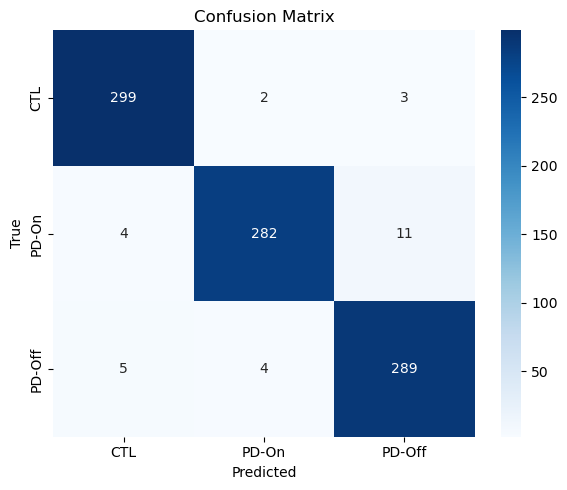

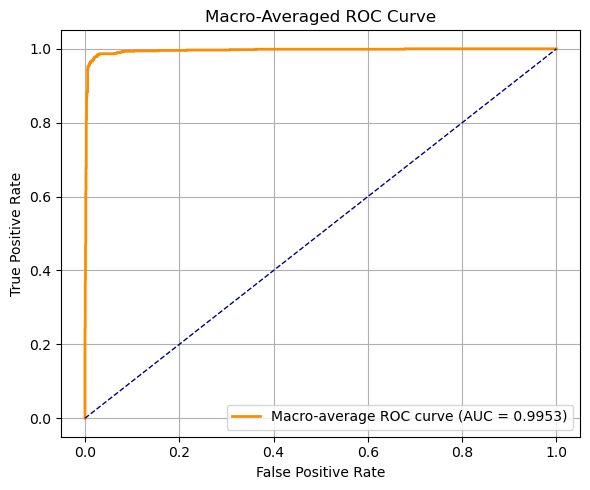

In [102]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=["CTL", "PD-On", "PD-Off"], columns=["CTL", "PD-On", "PD-Off"])
    plt.figure(figsize=(6, 5))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

def plot_macro_roc_curve(y_true, y_prob):
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
    y_prob = np.array(y_prob)
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Macro-average ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Macro-Averaged ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Your updated training + evaluation loop:
num_epochs = 40
all_y_true, all_y_pred, all_y_prob = [], [], []

for fold_idx, fold in enumerate(fold_data, 1):
    print(f"\n📁 ===== Fold {fold_idx} =====")

    train_loader = fold["train_loader"]
    val_loader = fold["val_loader"]
    class_weights = fold["class_weights"]

    model, loss_fn, optimizer, scheduler, device = initialize_training_components(
        input_dim=160,
        num_classes=3,
        class_weights_tensor=class_weights,
        train_loader=train_loader,
        epochs=num_epochs,
        lr=5e-4
    )

    # Train loop
    for epoch in range(1, num_epochs + 1):
        print(f"\n🌟 Epoch {epoch}/{num_epochs} — Fold {fold_idx}")
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, scheduler, device)
        print(f"✅ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # Final evaluation on validation set for this fold
    y_true, y_pred, y_prob = evaluate(model, val_loader, device, return_preds=True, show_plot=False)

    # Print classification report
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["CTL", "PD-On", "PD-Off"], digits=4))

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred)

    # Plot macro-average ROC AUC curve
    plot_macro_roc_curve(y_true, y_prob)

    # Collect all fold data for combined stats later
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)


**BLOCK 6:Evauluate**


📊 Final Cross-Validated Classification Report:
              precision    recall  f1-score   support

         CTL     0.9928    0.9928    0.9928      1520
       PD-On     0.9838    0.9765    0.9801      1488
      PD-Off     0.9740    0.9812    0.9776      1489

    accuracy                         0.9835      4497
   macro avg     0.9835    0.9835    0.9835      4497
weighted avg     0.9836    0.9835    0.9835      4497



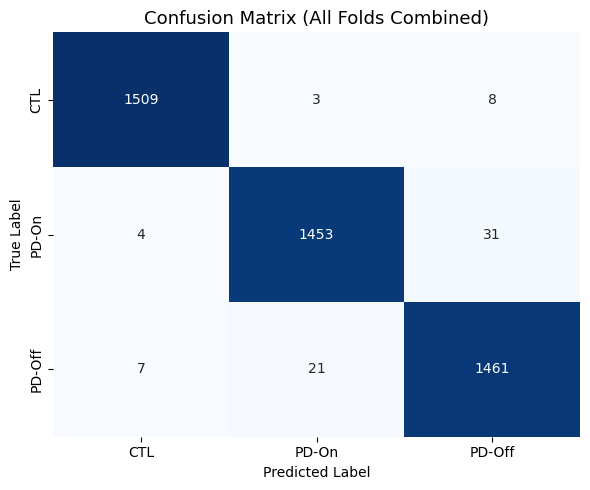

/var/folders/_j/y35nsxln38dd8dc1trg4qtnc0000gq/T/ipykernel_1907/1514851080.py:67: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/calebcooper/Downloads/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


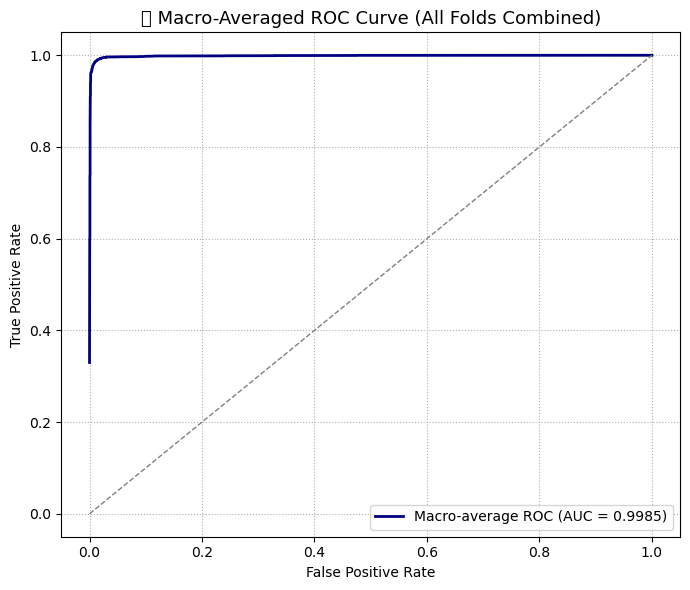

In [103]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# --- Final Classification Report and Confusion Matrix ---
print("\n📊 Final Cross-Validated Classification Report:")
print(classification_report(
    all_y_true, all_y_pred,
    target_names=["CTL", "PD-On", "PD-Off"],
    digits=4
))

cm = confusion_matrix(all_y_true, all_y_pred)
df_cm = pd.DataFrame(cm, index=["CTL", "PD-On", "PD-Off"], columns=["CTL", "PD-On", "PD-Off"])

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (All Folds Combined)", fontsize=13)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


# --- Macro-Averaged ROC Curve ---

# Binarize labels for multiclass ROC
y_true_bin = label_binarize(all_y_true, classes=[0, 1, 2])
y_prob = np.array(all_y_prob)

n_classes = y_true_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Aggregate all FPR points
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all TPRs at these points and average them
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

# Compute macro-average AUC
macro_auc = auc(all_fpr, mean_tpr)

# Plot macro-average ROC
plt.figure(figsize=(7, 6))
plt.plot(all_fpr, mean_tpr, color='navy', lw=2, label=f'Macro-average ROC (AUC = {macro_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 Macro-Averaged ROC Curve (All Folds Combined)', fontsize=13)
plt.legend(loc='lower right')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

